# **ĐỀ TÀI: NGHIÊN CỨU TRIỂN KHAI KIẾN TRÚC PHOBERT/VIBERT TRONG XỬ LÝ NGÔN NGỮ TỰ NHIÊN VÀ ÁP DỤNG VÀO VIỆC PHÂN TÍCH THÁI ĐỘ CỦA NGƯỜI HỌC TẠI UTC2**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Cài đặt thư viện***


In [ ]:
! pip install pyvi -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.6 MB/s eta 0:00:00


In [ ]:
!pip install transformers==4.49.0 -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 106.2 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow -qq

In [ ]:
!pip install keras -qq

In [ ]:
!pip install sentencepiece -qq

In [ ]:
!pip install vncorenlp -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 62.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Data Loader

In [ ]:
import numpy as np
import pandas as pd

train = pd.read_excel('/content/drive/MyDrive/NCKH_2425/DATASET/add_data/data/train.xlsx', header = 0, names = ['sentiment', 'sentence'])
dev = pd.read_excel('/content/drive/MyDrive/NCKH_2425/DATASET/add_data/data/valid.xlsx', header = 0, names = ['sentiment', 'sentence'])
test = pd.read_excel('/content/drive/MyDrive/NCKH_2425/DATASET/add_data/data/test.xlsx', header = 0, names = ['sentiment', 'sentence'])

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Đọc dữ liệu đã gộp
data = pd.read_excel('/content/drive/MyDrive/NCKH_2425/DATASET/add_data/combined_data_2.xlsx', header=0, names=['Sentiment', 'Sentences'])

# Chia dữ liệu thành train (70%), valid (15%), test (15%)
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['Sentiment'])
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['Sentiment'])

# Gán vào các biến
train = train_data
dev = valid_data
test = test_data

# In kích thước của các tập dữ liệu
print(f"Train size: {len(train)}, Validation size: {len(dev)}, Test size: {len(test)}")


Train size: 7118, Validation size: 1525, Test size: 1526


In [ ]:
from transformers import AutoTokenizer
import pandas as pd

# Tải tokenizer của PhoBERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

# Đọc dữ liệu từ file Excel
data = pd.read_excel('/content/drive/MyDrive/NCKH_2425/DATASET/add_data/combined_data_2.xlsx')

# Hàm đếm số token trong câu
def count_tokens(sentence):
    tokens = tokenizer.tokenize(sentence)
    return len(tokens)

# Xóa những dòng có số token > 512
data = data[data['Sentences'].apply(count_tokens) <= 300]

# Kiểm tra kết quả
print(data.head())
# Lưu DataFrame đã lọc vào file Excel mới
data.to_excel('/content/drive/MyDrive/NCKH_2425/DATASET/add_data/combined_data_2.xlsx', index=False)


In [ ]:
import pandas as pd

# Đọc dữ liệu từ file Excel (thay đổi đường dẫn nếu cần)
data = pd.read_excel('/content/drive/MyDrive/NCKH_2425/DATASET/add_data/combined_data_2.xlsx')

# Tính độ dài của mỗi bình luận (số từ trong mỗi câu)
data['Length'] = data['Sentences'].apply(lambda x: len(str(x).split()))

# Tính các thống kê
average_length = data['Length'].mean()  # Độ dài trung bình
min_length = data['Length'].min()  # Độ dài ngắn nhất
max_length = data['Length'].max()  # Độ dài dài nhất

# In kết quả
print(f"Độ dài trung bình: {average_length:.2f} từ")
print(f"Độ dài ngắn nhất: {min_length} từ")
print(f"Độ dài dài nhất: {max_length} từ")

Độ dài trung bình: 38.75 từ
Độ dài ngắn nhất: 2 từ
Độ dài dài nhất: 466 từ


In [ ]:
# @title ID

from matplotlib import pyplot as plt
train['ID'].plot(kind='hist', bins=20, title='ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

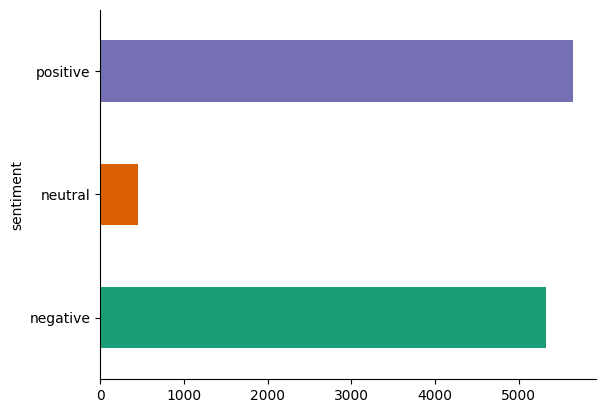

In [ ]:
# @title Attitude

from matplotlib import pyplot as plt
import seaborn as sns
train.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# # @title Attitude vs ID

# from matplotlib import pyplot as plt
# import seaborn as sns
# figsize = (12, 1.2 * len(train['Sentiment'].unique()))
# plt.figure(figsize=figsize)
# sns.violinplot(train, x='ID', y='Sentiment', inner='box', palette='Dark2')
# sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
from vncorenlp import VnCoreNLP
from pyvi.ViTokenizer import ViTokenizer
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
#pre-process
import re
import numpy as np

STOPWORDS = '/content/drive/MyDrive/NCKH_2425/DATASET/#dataVNstopwords/vietnamese-stopwords-dash.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)

    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized=True, lowercased=True):
    # text = ViTokenizer.tokenize(text)
    # text = ' '.join(vncorenlp.tokenize(text)[0])
    # text = filter_stop_words(text, stopwords)
    # text = deEmojify(text)
    # text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text

def pre_process_features(X, y, tokenized=True, lowercased=True):
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

X_train = train['sentence']
y_train = train['sentiment'].values
# y_train = train['Toxicity'].values

X_dev = dev['sentence']
y_dev = dev['sentiment'].values
# y_dev = dev['Toxicity'].values

X_test = test['sentence']
y_test = test['sentiment'].values
# y_test = test['Toxicity'].values


from sklearn.preprocessing import LabelEncoder

# Bien doi y bang label encoder thanh dang so
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)

encoder = LabelEncoder()
encoder.fit(y_dev)

y_dev = encoder.transform(y_dev)

encoder = LabelEncoder()
encoder.fit(y_test)

y_test = encoder.transform(y_test)

In [ ]:
# Kiểm tra các giá trị trong cột 'Sentiment' có phải là float không
is_float = X_dev.apply(lambda x: isinstance(x, float))

# In ra các dòng có giá trị là float trong cột 'Sentiment'
print(X_dev[is_float])


Series([], Name: Sentences, dtype: object)


In [ ]:
for i, sentence in enumerate(X_train):
    print(f"Câu {i+1}: {sentence}")


Câu 1: slide giáo trình đầy đủ .
Câu 2: nhiệt tình giảng dạy , gần gũi với sinh viên .
Câu 3: đi học đầy đủ full điểm chuyên cần .
Câu 4: chưa áp dụng công nghệ thông tin và các thiết bị hỗ trợ cho việc giảng dạy .
Câu 5: thầy giảng bài hay , có nhiều bài tập ví dụ ngay trên lớp .
Câu 6: giảng viên đảm bảo thời gian lên lớp , tích cực trả lời câu hỏi của sinh viên , thường xuyên đặt câu hỏi cho sinh viên .
Câu 7: em sẽ nợ môn này , nhưng em sẽ học lại ở các học kỳ kế tiếp .
Câu 8: thời lượng học quá dài , không đảm bảo tiếp thu hiệu quả .
Câu 9: nội dung môn học có phần thiếu trọng tâm , hầu như là chung chung , khái quát khiến sinh viên rất khó nắm được nội dung môn học .
Câu 10: cần nói rõ hơn bằng cách trình bày lên bảng thay vì nhìn vào slide .
Câu 11: thầy rất tận tình và đi dạy rất đúng giờ .
Câu 12: dễ bị áp lực .
Câu 13: đang dạy thầy wzjwz208 đi qua nước ngoài giữa chừng , thầy wzjwz209 dạy thay .
Câu 14: môn học còn dễ cần nâng độ khó lên nữa .
Câu 15: có thể cho sinh viên đi

**###TEST TIỀN XỬ LÝ DL**

In [ ]:
#preprocessing data
def Preprocess(string):
#   Remove các ký tự kéo dài: vd: đẹppppppp
    string = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), string, flags=re.IGNORECASE)
#     viết thường
    string = string.lower()
#     link
    string = re.sub('<.*?>', '', string).strip()
    string = re.sub('(\s)+', r'\1', string)
#     xóa ký tự đặt biệt
    string = re.sub(r"[-()\\\"#/@;:<>{}`+=~|.!?,%/]", "",string)
    string = re.sub('\n', ' ',string)
    string = re.sub('--', '',string)
    string = re.sub('  ', ' ',string)
    string = re.sub('   ', ' ',string)
    string = re.sub('    ', ' ',string)
#     xóa số
    string = re.sub(r"\d+", "number", string)
#     xóa
    string = re.sub("added.*photo", "", string)
    string = re.sub("added.*photos", "", string)
    string = re.sub("is.*post", "", string)
    string = re.sub("Photos.*post", "", string)
    string = re.sub("from.*post", "", string)
    string = re.sub("shared.*group", "", string)
    string = re.sub("shared.*post", "", string)
    string = re.sub("shared.*video", "", string)
    string = re.sub("is.*motivated", "", string)
    string = re.sub("is.*with", "", string)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    string = emoji_pattern.sub(r'', string)
        # xử lý emoj
    replace_list = {
                  # Positive
                  '🙂': 'Positive', '😀': 'Positive', '😄': 'Positive', '😆': 'Positive', '😅': 'Positive', '😂': 'Positive',
                  '😊': 'Positive', '😌': 'Positive', '😉': 'Positive', '😏': 'Positive', '😍': 'Positive', '🙃': 'Positive',
                  '😺': 'Positive', '🎃': 'Positive', '💩': 'Positive', '😎': 'Positive', '😋': 'Positive', '😜': 'Positive',
                  '😝': 'Positive', '😛': 'Positive', '😈': 'Positive', '😇': 'Positive', '😸': 'Positive', '😹': 'Positive',
                  '😼': 'Positive', '🌜': 'Positive', '🌛': 'Positive', '🌚': 'Positive', '🌝': 'Positive', '🌞': 'Positive',
                  '👍': 'Positive', '👌': 'Positive', '✌': 'Positive', '🙌': 'Positive', '💯': 'Positive', '🙋': 'Positive',
                  '✋': 'Positive', '✅': 'Positive', '✔': 'Positive', '👏': 'Positive', '💪': 'Positive',
                  '🙏': 'Positive', '☀': 'Positive', '👉': 'Positive', '🏃': 'Positive', '☝': 'Positive',

                  # Negative
                  '🙁': 'Negative', '☹': 'Negative', '😞': 'Negative', '😖': 'Negative', '😔': 'Negative', '😓': 'Negative',
                  '😢': 'Negative', '😭': 'Negative', '😟': 'Negative', '🙎': 'Negative', '😿': 'Negative',
                  '😰': 'Negative', '😱': 'Negative', '🙀': 'Negative', '😧': 'Negative', '😨': 'Negative',

                  # Neutral
                  '🙄': 'Neutral', '💥': 'Neutral', '😲': 'Neutral', '😳': 'Neutral'
              }




    for k, v in replace_list.items():
        string = string.replace(k, v)
#     remove nốt những ký tự thừa thãi


    string = string.replace(u'"', u' ')
    string = string.replace(u'️', u'')
    string = string.replace('🏻','')

    return string

for i in range(len(X_train)):
    X_train.values[i]=Preprocess(X_train.values[i])

for i in range(len(X_dev)):
    X_dev.values[i]=Preprocess(X_dev.values[i])

for i in range(len(X_test)):
    X_test.values[i]=Preprocess(X_test.values[i])

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2357417564.py:9: SyntaxWarning: invalid escape sequence '\s'
  string = re.sub('(\s)+', r'\1', string)


In [ ]:
dictionary = {}
with open("/content/drive/MyDrive/NCKH_2425/DATASET/tiengvietchuan.txt", "r") as file:
    for line in file:
        key, value = line.strip().split(",")
        key1 = str(key).strip()
        value1 = str(value).strip()
        dictionary[key1] = value1

print(dictionary)

{'\ufeff&': 'và', 'ă': 'ăn', 'a': 'anh', 'a.c.e': 'anh chị em', 'accept': 'chấp nhận', 'ace': 'anh chị em', 'ad': 'admin', 'addfr': 'kết bạn', 'ae': 'anh em', 'aiiii': 'ai', 'Aj': 'ai', 'ak': 'à', 'ák': 'á', 'all': 'mọi thứ', 'alo': 'gọi', 'ănn': 'ăn', 'atsm': 'ảo tưởng sức mạnh', 'auto': 'tự động', 'avatar': 'ảnh đại diện', 'b': 'bạn', 'baby': 'bé', 'bằg': 'bằng', 'bah': 'banh', 'bame': 'ba mẹ', 'bạn thăn': 'bạn thân', 'bđ': 'bê đê', 'bh': 'bao giờ', 'bik': 'biết', 'bit': 'biết', 'bjk': 'biết', 'bk': 'biết', 'bn': 'bao nhiêu', 'bnhiu': 'bao nhiêu', 'bòa': 'bò', 'bởiiii': 'bởi', 'bợn': 'bạn', 'bs': 'bác sĩ', 'bt': 'bình thường', 'bthg': 'bình thường', 'bùn': 'buồn', 'bus': 'xe buýt', 'bv': 'bệnh_viện', 'c': 'chị', 'cafe': 'cà phê', 'call me': 'gọi cho tôi', 'card': 'thẻ', 'care': 'quan tâm', 'cb': 'cán bộ', 'cc': 'con cặc', 'cđmm': 'con đĩ mẹ mày', 'ce': 'chị em', 'cf': 'cà phê', 'cg': 'cũng', 'ch': 'chị', 'chaj': 'chai', 'chiện': 'chuyện', 'chìu': 'chiều', 'chiu': 'chịu', 'chóa': 'chó

In [ ]:
def replace_string(text, dictionary):
    l = text.split(" ")
    for key in dictionary.keys():
        for item,va in enumerate(l):
            if va == key:
                l[item] = str(dictionary[key])
    result = " ".join(l)
    return result.strip()

for i in range(len(X_train)):
    X_train.values[i]=replace_string(X_train.values[i], dictionary)

for i in range(len(X_dev)):
    X_dev.values[i]=replace_string(X_dev.values[i], dictionary)

for i in range(len(X_test)):
    X_test.values[i]=replace_string(X_test.values[i], dictionary)

In [ ]:
# Khởi tạo 1 dict tổng
all_results = {}

## phobert-base

CUDA available: True
CUDA device: Tesla T4
Label distribution in training set: [5325  458 5643]
Label distribution in dev set: [705  73 805]
Label distribution in test set: [1409  167 1590]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Label dtype: int64
Label min: 0 Label max: 2
Unique labels: [0 1 2]


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.244900,0.240633
2,0.175200,0.221874
3,0.142100,0.224553
4,0.119200,0.250335
5,0.073000,0.249287
6,0.044100,0.251734


Epoch 1.00:
  Validation - Loss: 0.2406, Accuracy: 0.9438
  Test - Loss: 0.2884, Accuracy: 0.9302
Epoch 2.00:
  Validation - Loss: 0.2219, Accuracy: 0.9469
  Test - Loss: 0.2525, Accuracy: 0.9349
Epoch 3.00:
  Validation - Loss: 0.2246, Accuracy: 0.9526
  Test - Loss: 0.2635, Accuracy: 0.9397
Epoch 4.00:
  Validation - Loss: 0.2503, Accuracy: 0.9463
  Test - Loss: 0.2903, Accuracy: 0.9384
Epoch 5.00:
  Validation - Loss: 0.2493, Accuracy: 0.9482
  Test - Loss: 0.2986, Accuracy: 0.9387
Epoch 6.00:
  Validation - Loss: 0.2517, Accuracy: 0.9488
  Test - Loss: 0.3091, Accuracy: 0.9409


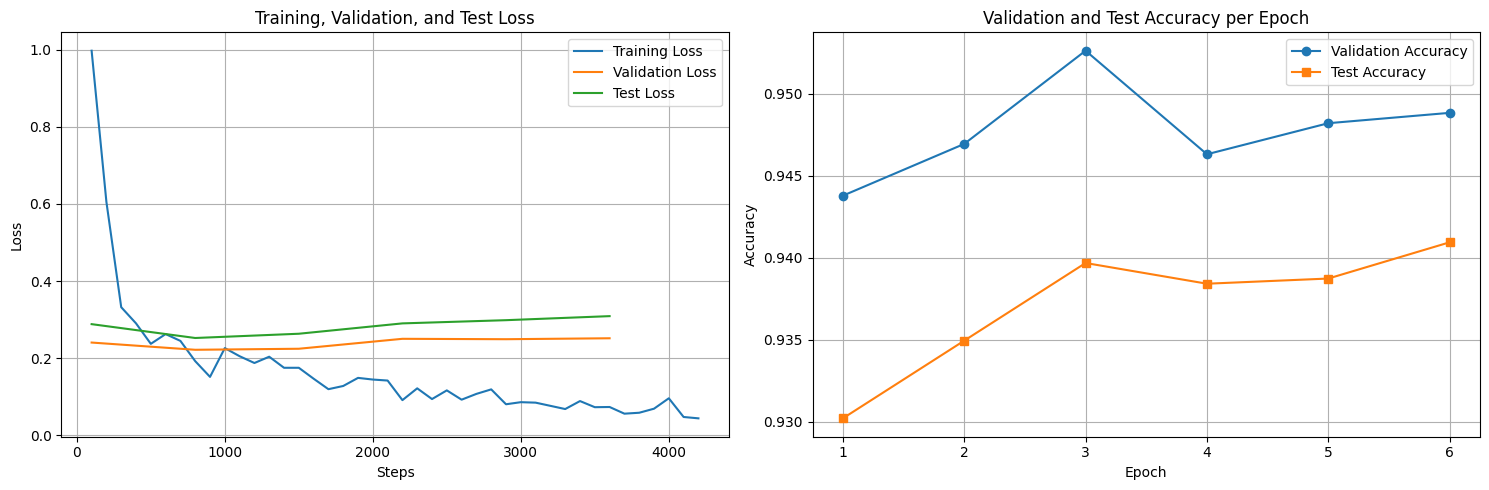


Accuracy Summary:
Epoch 1: Validation Accuracy = 0.9438, Test Accuracy = 0.9302
Epoch 2: Validation Accuracy = 0.9469, Test Accuracy = 0.9349
Epoch 3: Validation Accuracy = 0.9526, Test Accuracy = 0.9397
Epoch 4: Validation Accuracy = 0.9463, Test Accuracy = 0.9384
Epoch 5: Validation Accuracy = 0.9482, Test Accuracy = 0.9387
Epoch 6: Validation Accuracy = 0.9488, Test Accuracy = 0.9409

Best Validation Accuracy: 0.9526
Best Test Accuracy: 0.9409


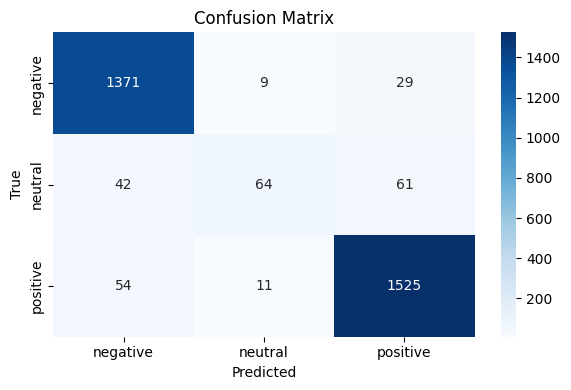

Final Test Accuracy: 0.9349
F1 - micro: 0.9349
Precision (macro): 0.8802
Recall (macro): 0.7718


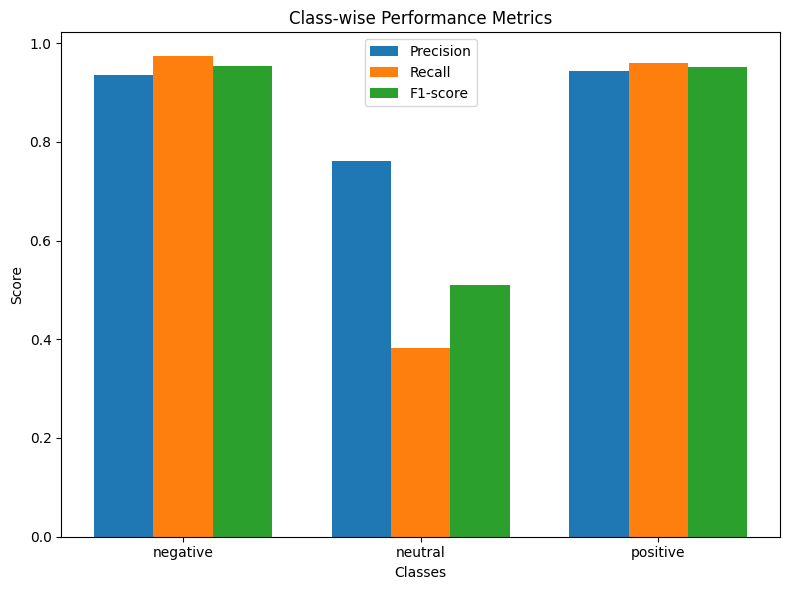

NameError: name 'all_results' is not defined

In [ ]:
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, precision_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback, TrainerCallback
from accelerate import Accelerator

# Set environment variables
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Make sure errors are reported immediately
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

# Verify your GPU is available and working
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Define label mapping (số → văn bản)
label_mapping = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

# Let's make sure your data is properly preprocessed
# Giả sử pre_process_features trả về nhãn dạng số
train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased=False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased=False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased=False)

# Lưu lại bản sao của nhãn số để sử dụng trong mô hình
train_y_numeric = train_y.copy()
dev_y_numeric = dev_y.copy()
test_y_numeric = test_y.copy()

# Check your labels to ensure they are in the correct format (0, 1, 2)
print(f"Label distribution in training set: {np.bincount(train_y)}")
print(f"Label distribution in dev set: {np.bincount(dev_y)}")
print(f"Label distribution in test set: {np.bincount(test_y)}")

# Verify the labels are within the expected range
assert all(0 <= y < 3 for y in train_y), "Training labels must be 0, 1, or 2"
assert all(0 <= y < 3 for y in dev_y), "Dev labels must be 0, 1, or 2"
assert all(0 <= y < 3 for y in test_y), "Test labels must be 0, 1, or 2"

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base-v2", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)

# Create Dataset class
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize with a smaller max_length to avoid memory issues
max_length = 100 # Reduced from 512
train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=max_length)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=max_length)

print("Label dtype:", train_y.dtype)
print("Label min:", train_y.min(), "Label max:", train_y.max())
print("Unique labels:", np.unique(train_y))

# Create datasets - sử dụng nhãn số cho việc huấn luyện
train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

# Enhanced callback to track train/val/test loss and accuracy
class LoggingCallback(TrainerCallback):
    def __init__(self, trainer_ref, test_dataset):
        self.trainer_ref = trainer_ref  # This will be set later
        self.test_dataset = test_dataset
        self.train_losses = []
        self.eval_losses = []
        self.test_losses = []
        self.eval_accuracies = []
        self.test_accuracies = []
        self.steps = []
        self.epochs = []

    def set_trainer(self, trainer):
        self.trainer_ref = trainer

    def on_train_begin(self, args, state, control, **kwargs):
        # This ensures the callback has a reference to the trainer
        if self.trainer_ref is None and 'trainer' in kwargs:
            self.trainer_ref = kwargs['trainer']

    def calculate_accuracy(self, predictions, true_labels):
        """Calculate accuracy from predictions and true labels"""
        pred_labels = np.argmax(predictions, axis=-1)
        return accuracy_score(true_labels, pred_labels)

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            # For training loss
            if "loss" in logs:
                self.train_losses.append(logs["loss"])
                self.steps.append(state.global_step)

            # For evaluation loss and accuracy (happens once per epoch)
            if "eval_loss" in logs:
                self.eval_losses.append(logs["eval_loss"])
                self.epochs.append(state.epoch)

                # Calculate validation accuracy
                if self.trainer_ref is not None:
                    # Get validation predictions
                    val_outputs = self.trainer_ref.predict(self.trainer_ref.eval_dataset)
                    val_accuracy = self.calculate_accuracy(val_outputs.predictions, val_outputs.label_ids)
                    self.eval_accuracies.append(val_accuracy)

                    # Calculate test accuracy and loss
                    test_outputs = self.trainer_ref.predict(self.test_dataset)
                    test_loss = test_outputs.metrics["test_loss"]
                    test_accuracy = self.calculate_accuracy(test_outputs.predictions, test_outputs.label_ids)

                    self.test_losses.append(test_loss)
                    self.test_accuracies.append(test_accuracy)

                    print(f"Epoch {state.epoch:.2f}:")
                    print(f"  Validation - Loss: {logs['eval_loss']:.4f}, Accuracy: {val_accuracy:.4f}")
                    print(f"  Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Modify training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/NCKH_2425/PhoBERT/PhoBERT_base',
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="epoch",  # Changed from eval_strategy
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # Lower eval_loss is better
    do_eval=True,
    no_cuda=False,
    fp16=False,  # Disable mixed precision to help with debugging
)

# Initialize our custom logging callback with None for trainer_ref
logging_callback = LoggingCallback(None, test_dataset)

# Initialize Trainer with the callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    callbacks=[logging_callback],
)

# Set trainer in callback after initialization
logging_callback.set_trainer(trainer)

# Dictionary to store metrics history
history = {
    'train_loss': [],
    'val_loss': [],
    'test_loss': [],
    'val_accuracy': [],
    'test_accuracy': []
}

accelerator = Accelerator()

# Train the model with error handling
try:
    # Train the model and collect training/validation loss at each epoch
    train_result = trainer.train()

    # Get training metrics
    metrics = train_result.metrics

    # Save model
    trainer.save_model("/content/drive/MyDrive/NCKH_2425/PhoBERT/PhoBERT_base")

    # Plot training and validation loss
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(logging_callback.steps, logging_callback.train_losses, label='Training Loss')

    # Check if we collected evaluation metrics
    if logging_callback.eval_losses and logging_callback.test_losses:
        # Calculate proper x-coordinates for eval and test losses
        eval_step_interval = max(1, len(logging_callback.steps) // len(logging_callback.eval_losses))
        eval_steps = [logging_callback.steps[min(i * eval_step_interval, len(logging_callback.steps) - 1)]
                      for i in range(len(logging_callback.eval_losses))]

        plt.plot(eval_steps, logging_callback.eval_losses, label='Validation Loss')
        plt.plot(eval_steps, logging_callback.test_losses, label='Test Loss')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training, Validation, and Test Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    if logging_callback.eval_accuracies and logging_callback.test_accuracies:
        epochs = list(range(1, len(logging_callback.eval_accuracies) + 1))
        plt.plot(epochs, logging_callback.eval_accuracies, label='Validation Accuracy', marker='o')
        plt.plot(epochs, logging_callback.test_accuracies, label='Test Accuracy', marker='s')

        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Validation and Test Accuracy per Epoch')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

    # Print accuracy summary
    if logging_callback.eval_accuracies and logging_callback.test_accuracies:
        print("\nAccuracy Summary:")
        print("=" * 50)
        for i, (val_acc, test_acc) in enumerate(zip(logging_callback.eval_accuracies, logging_callback.test_accuracies), 1):
            print(f"Epoch {i}: Validation Accuracy = {val_acc:.4f}, Test Accuracy = {test_acc:.4f}")

        print(f"\nBest Validation Accuracy: {max(logging_callback.eval_accuracies):.4f}")
        print(f"Best Test Accuracy: {max(logging_callback.test_accuracies):.4f}")

    # Evaluate on test set
    y_pred_classify = trainer.predict(test_dataset)
    y_pred_ids = np.argmax(y_pred_classify.predictions, axis=-1)

    # Chuyển đổi nhãn số thành nhãn văn bản
    y_pred_text = [label_mapping[idx] for idx in y_pred_ids]
    y_true_text = [label_mapping[idx] for idx in test_y]

    # Sử dụng nhãn số cho tính toán các metrics
    y_true = test_y

    # Create a confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_ids)
    plt.figure(figsize=(6, 4))  # Smaller size
    sn.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues",
               xticklabels=["negative", "neutral", "positive"],
               yticklabels=["negative", "neutral", "positive"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()  # Ensure all elements fit in the figure
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Print metrics
    acc = accuracy_score(y_true, y_pred_ids)
    print("Final Test Accuracy: {:.4f}".format(acc))

    f1_micro = f1_score(y_true, y_pred_ids, average='micro')
    print("F1 - micro: {:.4f}".format(f1_micro))

    precision = precision_score(y_true, y_pred_ids, average='macro')
    print("Precision (macro): {:.4f}".format(precision))

    recall = recall_score(y_true, y_pred_ids, average='macro')
    print("Recall (macro): {:.4f}".format(recall))

    # Plot class-wise metrics
    class_names = ["negative", "neutral", "positive"]
    class_precision = precision_score(y_true, y_pred_ids, average=None)
    class_recall = recall_score(y_true, y_pred_ids, average=None)
    class_f1 = f1_score(y_true, y_pred_ids, average=None)

    plt.figure(figsize=(8, 6))
    x = np.arange(len(class_names))
    width = 0.25

    plt.bar(x - width, class_precision, width, label='Precision')
    plt.bar(x, class_recall, width, label='Recall')
    plt.bar(x + width, class_f1, width, label='F1-score')

    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Class-wise Performance Metrics')
    plt.xticks(x, class_names)
    plt.legend()
    plt.tight_layout()
    plt.savefig('class_metrics.png')
    plt.show()

    model_name = "PhoBert"
    metrics = {
        "accuracy": acc,
        "f1_micro": f1_micro,
        "precision": precision,
        "recall": recall
    }
    all_results[model_name] = metrics

    # Print some example predictions with text labels
    print("\nExample predictions:")
    print("------------------------")
    for i in range(min(10, len(test_X))):
        print(f"Text: {test_X[i][:50]}...")
        print(f"True sentiment: {y_true_text[i]}")
        print(f"Predicted sentiment: {y_pred_text[i]}")
        print("------------------------")

except RuntimeError as e:
    print(f"Runtime error encountered: {e}")

    # Print GPU memory usage for debugging
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
        print(f"GPU memory cached: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
        torch.cuda.empty_cache()  # Free up GPU memory

# Bert4news

Label distribution in training set: [2495 2326 2297]
Label distribution in dev set: [534 498 493]
Label distribution in test set: [535 499 492]


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting training...


Epoch,Training Loss,Validation Loss
1,0.012100,0.980975
2,0.050900,0.960397
3,0.015300,0.974098
4,0.015400,0.949912
5,0.004100,0.949000
6,0.003900,0.958644


Epoch 1.00:
  Validation - Loss: 0.9810, Accuracy: 0.8859
  Test - Loss: 0.8302, Accuracy: 0.9037
Epoch 2.00:
  Validation - Loss: 0.9604, Accuracy: 0.8813
  Test - Loss: 0.8580, Accuracy: 0.8860
Epoch 3.00:
  Validation - Loss: 0.9741, Accuracy: 0.8807
  Test - Loss: 0.7845, Accuracy: 0.8997
Epoch 4.00:
  Validation - Loss: 0.9499, Accuracy: 0.8826
  Test - Loss: 0.7995, Accuracy: 0.8965
Epoch 5.00:
  Validation - Loss: 0.9490, Accuracy: 0.8866
  Test - Loss: 0.8322, Accuracy: 0.8997
Epoch 6.00:
  Validation - Loss: 0.9586, Accuracy: 0.8898
  Test - Loss: 0.8370, Accuracy: 0.9030
Training completed and model saved.


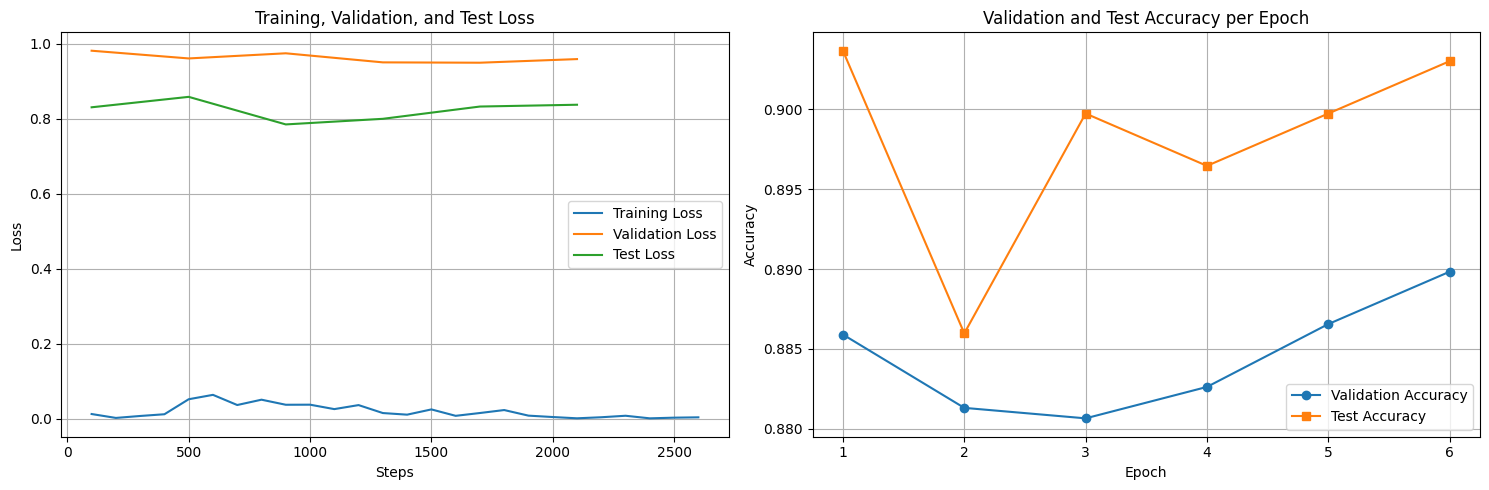


Accuracy Summary:
Epoch 1: Validation Accuracy = 0.8859, Test Accuracy = 0.9037
Epoch 2: Validation Accuracy = 0.8813, Test Accuracy = 0.8860
Epoch 3: Validation Accuracy = 0.8807, Test Accuracy = 0.8997
Epoch 4: Validation Accuracy = 0.8826, Test Accuracy = 0.8965
Epoch 5: Validation Accuracy = 0.8866, Test Accuracy = 0.8997
Epoch 6: Validation Accuracy = 0.8898, Test Accuracy = 0.9030

Best Validation Accuracy: 0.8898
Best Test Accuracy: 0.9037


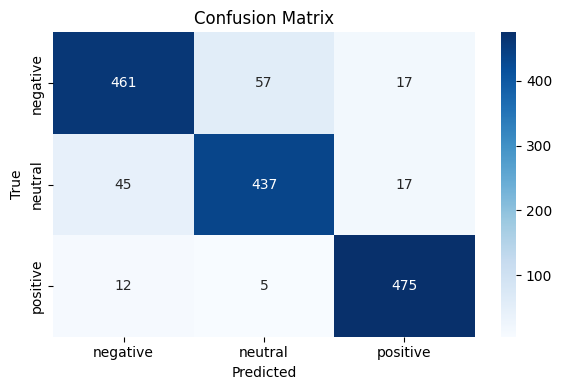

Final Test Accuracy: 0.8997
F1 - micro: 0.8997
Precision (macro): 0.8996
Recall (macro): 0.9010


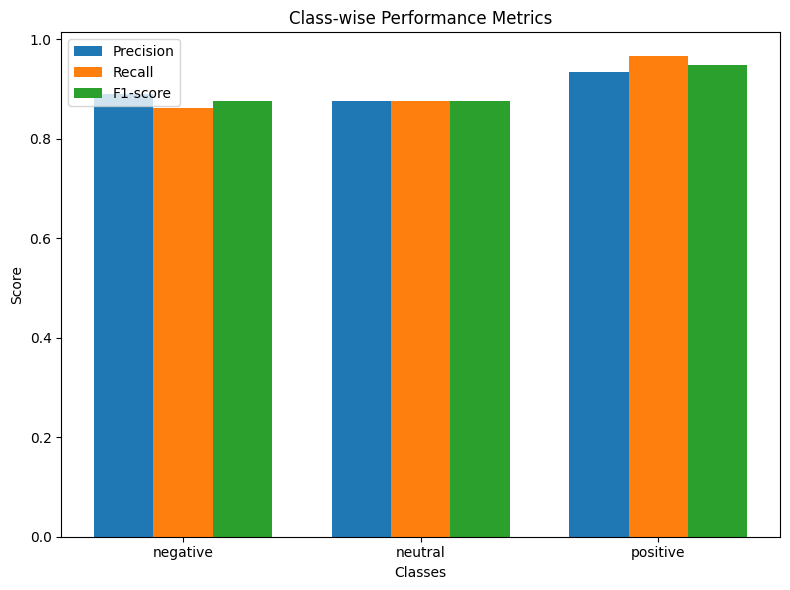


Example predictions:
------------------------
Text: number sao sinh viên mà ý thứ là sv* vậy ăn kẹo ca...
True sentiment: negative
Predicted sentiment: negative
------------------------
Text: thầy nên sử dụng micro để giảng...
True sentiment: negative
Predicted sentiment: negative
------------------------
Text: kính thưa thầy cô trong bđt em có vấn đề này xin đ...
True sentiment: neutral
Predicted sentiment: neutral
------------------------
Text: rất hài lòng về giảng viên...
True sentiment: positive
Predicted sentiment: positive
------------------------
Text: em thấy thầy giảng hơi bị buồn ngủ...
True sentiment: positive
Predicted sentiment: negative
------------------------
Text: em vô cùng cảm ơn thầycô đã luôn quan tâm hỗ trợ v...
True sentiment: positive
Predicted sentiment: positive
------------------------
Text: chưa có diễn đàn trên courses...
True sentiment: negative
Predicted sentiment: negative
------------------------
Text: đảm bảo đủ giờ lên lớp...
True sentiment: positiv

In [ ]:
# Bert4news - Training on Colab with Per-Epoch Accuracy Tracking

# 1. Import libraries
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, precision_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback, TrainerCallback, set_seed

# 2. Setup
# Set environment variables for better logging
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

# Set random seed
set_seed(42)

# Label mapping
label_mapping = {0: "negative", 1: "neutral", 2: "positive"}

# Model & output directory (for Colab)
base_model_dir = "/content/drive/MyDrive/NCKH_2425/ViBert4News/Base"

# 3. Preprocess data
train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased=False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased=False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased=False)

print(f"Label distribution in training set: {np.bincount(train_y)}")
print(f"Label distribution in dev set: {np.bincount(dev_y)}")
print(f"Label distribution in test set: {np.bincount(test_y)}")

# 4. Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(base_model_dir, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(base_model_dir, use_fast=True)

# 5. Dataset class
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize data
train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=512)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=512)

# Create datasets
train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

# 6. Enhanced Loss and Accuracy Tracking Callback
class LossTrackingCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.test_losses = []
        self.eval_accuracies = []
        self.test_accuracies = []
        self.steps = []
        self.epochs = []
        self.trainer = None
        self.test_dataset = None

    def on_train_begin(self, args, state, control, **kwargs):
        if 'trainer' in kwargs:
            self.trainer = kwargs['trainer']

    def set_trainer_and_dataset(self, trainer, test_dataset):
        self.trainer = trainer
        self.test_dataset = test_dataset

    def calculate_accuracy(self, predictions, true_labels):
        """Calculate accuracy from predictions and true labels"""
        pred_labels = np.argmax(predictions, axis=-1)
        return accuracy_score(true_labels, pred_labels)

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_losses.append(logs["loss"])
                self.steps.append(state.global_step)

            if "eval_loss" in logs:
                self.eval_losses.append(logs["eval_loss"])
                self.epochs.append(state.epoch)

                if self.trainer is not None and self.test_dataset is not None:
                    # Calculate validation accuracy
                    val_outputs = self.trainer.predict(self.trainer.eval_dataset)
                    val_accuracy = self.calculate_accuracy(val_outputs.predictions, val_outputs.label_ids)
                    self.eval_accuracies.append(val_accuracy)

                    # Calculate test accuracy and loss
                    test_outputs = self.trainer.predict(self.test_dataset)
                    test_loss = test_outputs.metrics["test_loss"]
                    test_accuracy = self.calculate_accuracy(test_outputs.predictions, test_outputs.label_ids)

                    self.test_losses.append(test_loss)
                    self.test_accuracies.append(test_accuracy)

                    print(f"Epoch {state.epoch:.2f}:")
                    print(f"  Validation - Loss: {logs['eval_loss']:.4f}, Accuracy: {val_accuracy:.4f}")
                    print(f"  Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# 7. Training arguments
training_args = TrainingArguments(
    output_dir=base_model_dir,
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    no_cuda=False,
    do_eval=True
)

# Early stopping
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=4)

# Initialize loss tracker
loss_tracker = LossTrackingCallback()

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    callbacks=[early_stopping_callback, loss_tracker],
)

loss_tracker.set_trainer_and_dataset(trainer, test_dataset)

# 8. Train model
print("Starting training...")
trainer.train()
trainer.save_model(base_model_dir)
print("Training completed and model saved.")

# 9. Plot training, validation, and test loss & accuracy
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(loss_tracker.steps, loss_tracker.train_losses, label='Training Loss')

if loss_tracker.eval_losses and loss_tracker.test_losses:
    eval_step_interval = max(1, len(loss_tracker.steps) // len(loss_tracker.eval_losses))
    eval_steps = [loss_tracker.steps[min(i * eval_step_interval, len(loss_tracker.steps) - 1)] for i in range(len(loss_tracker.eval_losses))]
    plt.plot(eval_steps, loss_tracker.eval_losses, label='Validation Loss')
    plt.plot(eval_steps, loss_tracker.test_losses, label='Test Loss')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
if loss_tracker.eval_accuracies and loss_tracker.test_accuracies:
    epochs = list(range(1, len(loss_tracker.eval_accuracies) + 1))
    plt.plot(epochs, loss_tracker.eval_accuracies, label='Validation Accuracy', marker='o')
    plt.plot(epochs, loss_tracker.test_accuracies, label='Test Accuracy', marker='s')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation and Test Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('vibert4news_training_metrics.png')
plt.show()

# Print accuracy summary
if loss_tracker.eval_accuracies and loss_tracker.test_accuracies:
    print("\nAccuracy Summary:")
    print("=" * 50)
    for i, (val_acc, test_acc) in enumerate(zip(loss_tracker.eval_accuracies, loss_tracker.test_accuracies), 1):
        print(f"Epoch {i}: Validation Accuracy = {val_acc:.4f}, Test Accuracy = {test_acc:.4f}")

    print(f"\nBest Validation Accuracy: {max(loss_tracker.eval_accuracies):.4f}")
    print(f"Best Test Accuracy: {max(loss_tracker.test_accuracies):.4f}")

# 10. Evaluate on test set
y_pred_classify = trainer.predict(test_dataset)
y_pred_ids = np.argmax(y_pred_classify.predictions, axis=-1)

# Map IDs to text labels
y_pred_text = [label_mapping[idx] for idx in y_pred_ids]
y_true_text = [label_mapping[idx] for idx in test_y]

# Metrics
y_true = test_y

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred_ids)
plt.figure(figsize=(6, 4))
sn.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues",
           xticklabels=["negative", "neutral", "positive"],
           yticklabels=["negative", "neutral", "positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('vibert4news_confusion_matrix.png')
plt.show()

# Scores
acc = accuracy_score(y_true, y_pred_ids)
print("Final Test Accuracy: {:.4f}".format(acc))

f1_micro = f1_score(y_true, y_pred_ids, average='micro')
print("F1 - micro: {:.4f}".format(f1_micro))

precision = precision_score(y_true, y_pred_ids, average='macro')
print("Precision (macro): {:.4f}".format(precision))

recall = recall_score(y_true, y_pred_ids, average='macro')
print("Recall (macro): {:.4f}".format(recall))

# 11. Plot class-wise metrics
class_names = ["negative", "neutral", "positive"]
class_precision = precision_score(y_true, y_pred_ids, average=None)
class_recall = recall_score(y_true, y_pred_ids, average=None)
class_f1 = f1_score(y_true, y_pred_ids, average=None)

plt.figure(figsize=(8, 6))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, class_precision, width, label='Precision')
plt.bar(x, class_recall, width, label='Recall')
plt.bar(x + width, class_f1, width, label='F1-score')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Class-wise Performance Metrics')
plt.xticks(x, class_names)
plt.legend()
plt.tight_layout()
plt.savefig('vibert4news_class_metrics.png')
plt.show()

model_name = "ViBert4News"
metrics = {
    "accuracy": acc,
    "f1_micro": f1_micro,
    "precision": precision,
    "recall": recall
}
all_results[model_name] = metrics

# 12. Print some example predictions
print("\nExample predictions:")
print("------------------------")
for i in range(min(10, len(test_X))):
    print(f"Text: {test_X[i][:50]}...")
    print(f"True sentiment: {y_true_text[i]}")
    print(f"Predicted sentiment: {y_pred_text[i]}")
    print("------------------------")

## vibert-base-cased

Label distribution in training set: [2495 2326 2297]
Label distribution in dev set: [534 498 493]
Label distribution in test set: [535 499 492]


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting training...


Epoch,Training Loss,Validation Loss
1,0.171100,0.744799
2,0.164800,0.908386
3,0.099200,0.921148


Epoch 1.00: Validation loss: 0.7448, Test loss: 0.5719
Epoch 2.00: Validation loss: 0.9084, Test loss: 0.7074
Epoch 3.00: Validation loss: 0.9211, Test loss: 0.7667
Training completed and model saved.


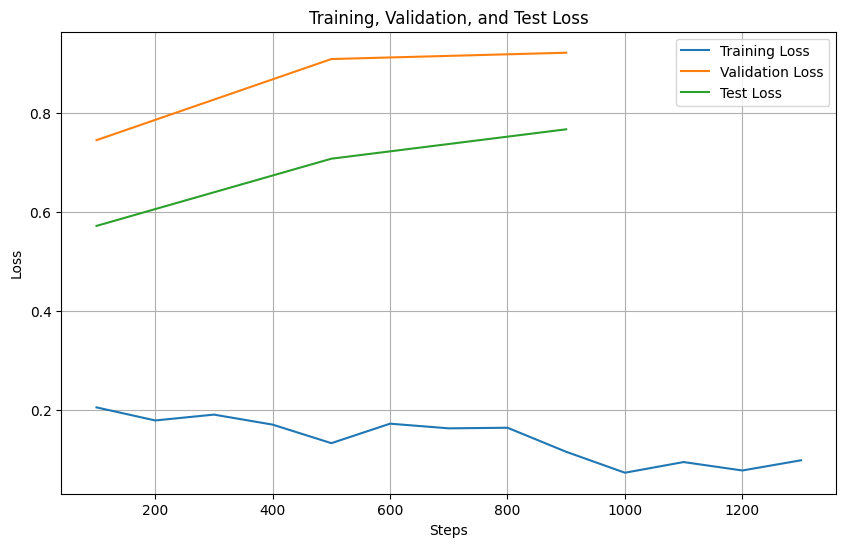

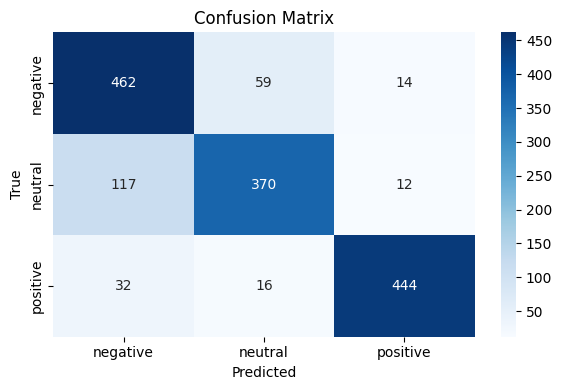

Accuracy: 0.8362
F1 - micro: 0.8362
Precision (micro): 0.8441
Recall (micro): 0.8358


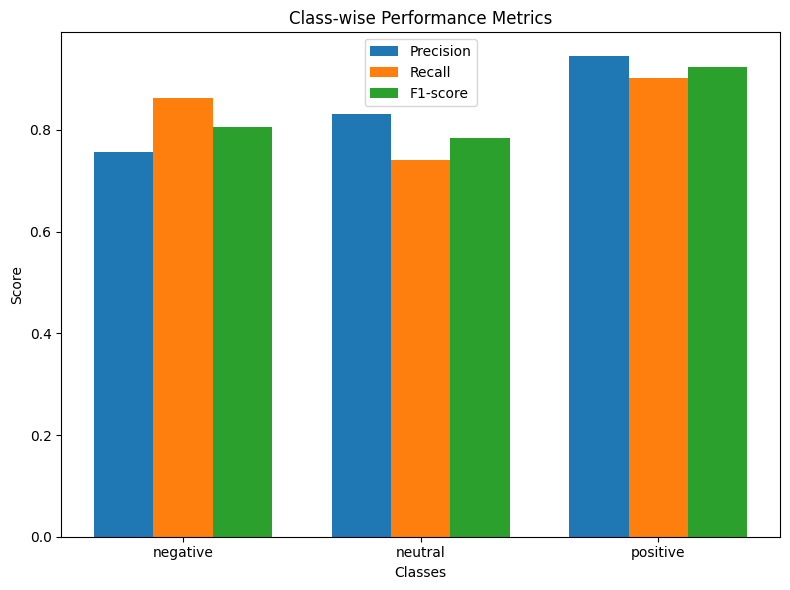


Example predictions:
------------------------
Text: number sao sinh viên mà ý thứ là sv* vậy ăn kẹo ca...
True sentiment: negative
Predicted sentiment: neutral
------------------------
Text: thầy nên sử dụng micro để giảng...
True sentiment: negative
Predicted sentiment: negative
------------------------
Text: kính thưa thầy cô trong bđt em có vấn đề này xin đ...
True sentiment: neutral
Predicted sentiment: neutral
------------------------
Text: rất hài lòng về giảng viên...
True sentiment: positive
Predicted sentiment: positive
------------------------
Text: em thấy thầy giảng hơi bị buồn ngủ...
True sentiment: positive
Predicted sentiment: negative
------------------------
Text: em vô cùng cảm ơn thầycô đã luôn quan tâm hỗ trợ v...
True sentiment: positive
Predicted sentiment: positive
------------------------
Text: chưa có diễn đàn trên courses...
True sentiment: negative
Predicted sentiment: negative
------------------------
Text: đảm bảo đủ giờ lên lớp...
True sentiment: positive

In [ ]:
# Bert4news - Training on Colab

# 1. Import libraries
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, precision_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback, TrainerCallback, set_seed

# 2. Setup
# Set environment variables for better logging
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

# Set random seed
set_seed(42)

# Label mapping
label_mapping = {0: "negative", 1: "neutral", 2: "positive"}

# Model & output directory (for Colab)
base_model_dir = "/content/drive/MyDrive/NCKH_2425/ViBert/Base"

# 3. Preprocess data
train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased=False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased=False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased=False)

print(f"Label distribution in training set: {np.bincount(train_y)}")
print(f"Label distribution in dev set: {np.bincount(dev_y)}")
print(f"Label distribution in test set: {np.bincount(test_y)}")

# 4. Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(base_model_dir, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(base_model_dir, use_fast=True)

# 5. Dataset class
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize data
train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=512)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=512)

# Create datasets
train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

# 6. Custom Loss Tracking Callback
class LossTrackingCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.test_losses = []
        self.steps = []
        self.epochs = []
        self.trainer = None
        self.test_dataset = None

    def on_train_begin(self, args, state, control, **kwargs):
        if 'trainer' in kwargs:
            self.trainer = kwargs['trainer']

    def set_trainer_and_dataset(self, trainer, test_dataset):
        self.trainer = trainer
        self.test_dataset = test_dataset

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_losses.append(logs["loss"])
                self.steps.append(state.global_step)
            if "eval_loss" in logs:
                self.eval_losses.append(logs["eval_loss"])
                if self.trainer is not None and self.test_dataset is not None:
                    test_outputs = self.trainer.predict(self.test_dataset)
                    test_loss = test_outputs.metrics["test_loss"]
                    self.test_losses.append(test_loss)
                    self.epochs.append(state.epoch)
                    print(f"Epoch {state.epoch:.2f}: Validation loss: {logs['eval_loss']:.4f}, Test loss: {test_loss:.4f}")

# 7. Training arguments
training_args = TrainingArguments(
    output_dir=base_model_dir,
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    no_cuda=False,
    do_eval=True
)

# Early stopping
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

# Initialize loss tracker
loss_tracker = LossTrackingCallback()

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    callbacks=[early_stopping_callback, loss_tracker],
)

loss_tracker.set_trainer_and_dataset(trainer, test_dataset)

# 8. Train model
print("Starting training...")
trainer.train()
trainer.save_model(base_model_dir)
print("Training completed and model saved.")

# 9. Plot training, validation, and test loss
plt.figure(figsize=(10, 6))
plt.plot(loss_tracker.steps, loss_tracker.train_losses, label='Training Loss')

if loss_tracker.eval_losses and loss_tracker.test_losses:
    eval_step_interval = max(1, len(loss_tracker.steps) // len(loss_tracker.eval_losses))
    eval_steps = [loss_tracker.steps[min(i * eval_step_interval, len(loss_tracker.steps) - 1)] for i in range(len(loss_tracker.eval_losses))]
    plt.plot(eval_steps, loss_tracker.eval_losses, label='Validation Loss')
    plt.plot(eval_steps, loss_tracker.test_losses, label='Test Loss')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curves.png')
plt.show()

# 10. Evaluate on test set
y_pred_classify = trainer.predict(test_dataset)
y_pred_ids = np.argmax(y_pred_classify.predictions, axis=-1)

# Map IDs to text labels
y_pred_text = [label_mapping[idx] for idx in y_pred_ids]
y_true_text = [label_mapping[idx] for idx in test_y]

# Metrics
y_true = test_y

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred_ids)
plt.figure(figsize=(6, 4))
sn.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues",
           xticklabels=["negative", "neutral", "positive"],
           yticklabels=["negative", "neutral", "positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Scores
acc = accuracy_score(y_true, y_pred_ids)
print("Accuracy: {:.4f}".format(acc))

f1_micro = f1_score(y_true, y_pred_ids, average='micro')
print("F1 - micro: {:.4f}".format(f1_micro))

precision = precision_score(y_true, y_pred_ids, average='macro')
print("Precision (micro): {:.4f}".format(precision))

recall = recall_score(y_true, y_pred_ids, average='macro')
print("Recall (micro): {:.4f}".format(recall))

# 11. Plot class-wise metrics
class_names = ["negative", "neutral", "positive"]
class_precision = precision_score(y_true, y_pred_ids, average=None)
class_recall = recall_score(y_true, y_pred_ids, average=None)
class_f1 = f1_score(y_true, y_pred_ids, average=None)

plt.figure(figsize=(8, 6))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, class_precision, width, label='Precision')
plt.bar(x, class_recall, width, label='Recall')
plt.bar(x + width, class_f1, width, label='F1-score')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Class-wise Performance Metrics')
plt.xticks(x, class_names)
plt.legend()
plt.tight_layout()
plt.savefig('vibert4news_class_metrics.png')
plt.show()


model_name = "ViBert"
metrics = {
    "accuracy": acc,
    "f1_micro": f1_micro,
    "precision": precision,
    "recall": recall
}
all_results[model_name] = metrics

# 12. Print some example predictions
print("\nExample predictions:")
print("------------------------")
for i in range(min(10, len(test_X))):
    print(f"Text: {test_X[i][:50]}...")
    print(f"True sentiment: {y_true_text[i]}")
    print(f"Predicted sentiment: {y_pred_text[i]}")
    print("------------------------")


# XLM-RoBEARTa

Label distribution in training set: [2495 2326 2297]
Label distribution in dev set: [534 498 493]
Label distribution in test set: [535 499 492]


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting XLM-RoBERTa training...


Epoch,Training Loss,Validation Loss
1,0.524400,0.446527
2,0.444100,0.390713
3,0.312600,0.373485
4,0.256600,0.421268
5,0.227200,0.510250


Training completed and model saved.


ValueError: max() arg is an empty sequence

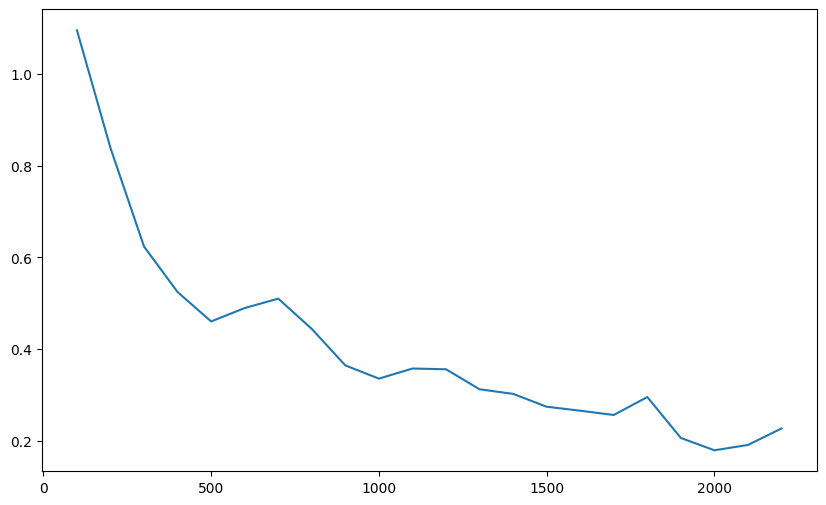

In [ ]:
# XLM-RoBERTa training full code

import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, precision_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, TrainerCallback

# Set environment variables
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

# Preprocess data
train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased=False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased=False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased=False)

# Label distribution
print(f"Label distribution in training set: {np.bincount(train_y)}")
print(f"Label distribution in dev set: {np.bincount(dev_y)}")
print(f"Label distribution in test set: {np.bincount(test_y)}")

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=3
)
tokenizer = AutoTokenizer.from_pretrained(
    "xlm-roberta-base",
    use_fast=True
)

# Dataset class
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize data
train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=512)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=512)

# Create datasets
train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

# Custom callback to track train/val/test loss
class LossTrackingCallback(TrainerCallback):
    def __init__(self, trainer, test_dataset):
        self.trainer = trainer
        self.test_dataset = test_dataset
        self.train_losses = []
        self.eval_losses = []
        self.test_losses = []
        self.steps = []
        self.epochs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            self.train_losses.append(logs["loss"])
            self.steps.append(state.global_step)

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        if "eval_loss" in metrics:
            self.eval_losses.append(metrics["eval_loss"])
            self.epochs.append(state.epoch)

            # Predict test loss
            test_outputs = self.trainer.predict(self.test_dataset)
            test_loss = test_outputs.metrics.get("eval_loss", None)
            if test_loss is not None:
                self.test_losses.append(test_loss)
            else:
                self.test_losses.append(-1)

# Training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/NCKH_2425/XLM-RoBERTa',
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    no_cuda=False,
    do_eval=True
)

# Callbacks
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    callbacks=[early_stopping_callback]
)

# Add loss tracking
loss_tracker = LossTrackingCallback(trainer, test_dataset)
trainer.add_callback(loss_tracker)

# Train model
print("Starting XLM-RoBERTa training...")
trainer.train()
trainer.save_model("/content/drive/MyDrive/NCKH_2425/XLM-RoBERTa")
print("Training completed and model saved.")

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(loss_tracker.steps, loss_tracker.train_losses, label='Training Loss')
if loss_tracker.eval_losses:
    eval_steps = [max(s for s in loss_tracker.steps if s <= (e * len(loss_tracker.steps)/6))
                  for e in range(1, len(loss_tracker.eval_losses) + 1)]
    plt.plot(eval_steps, loss_tracker.eval_losses, label='Validation Loss')
    plt.plot(eval_steps, loss_tracker.test_losses, label='Test Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('xlm_roberta_loss_curves.png')
plt.show()

# Evaluate on test set
print("Evaluating on test set...")
y_pred_classify = trainer.predict(test_dataset)
y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

# Confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sn.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues",
           xticklabels=["Negative", "Neutral", "Positive"],
           yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn')
plt.tight_layout()
plt.savefig('xlm_roberta_confusion_matrix.png')
plt.show()

# Calculate metrics
acc = accuracy_score(y_true, y_pred)
f1_micro = f1_score(y_true, y_pred, average='micro')
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')

print(f"Accuracy: {acc:.4f}")
print(f"F1 - micro: {f1_micro:.4f}")
print(f"Precision (micro): {precision:.4f}")
print(f"Recall (micro): {recall:.4f}")

# Per-class metrics
class_names = ["Negative", "Neutral", "Positive"]
class_precision = precision_score(y_true, y_pred, average=None)
class_recall = recall_score(y_true, y_pred, average=None)
class_f1 = f1_score(y_true, y_pred, average=None)

# Plot class-wise metrics
plt.figure(figsize=(8, 6))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, class_precision, width, label='Độ chính xác')
plt.bar(x, class_recall, width, label='Độ bao phủ')
plt.bar(x + width, class_f1, width, label='Điểm F1')

plt.xlabel('Các lớp')
plt.ylabel('Điểm số')
plt.title('Đánh giá chi tiết theo lớp')
plt.xticks(x, class_names)
plt.legend()
plt.tight_layout()
plt.savefig('xlm_roberta_class_metrics.png')
plt.show()

# Summary table
summary_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 (micro)', 'Precision (micro)', 'Recall (micro)'],
    'Score': [acc, f1_micro, precision, recall]
})

model_name = "XLM-RoBerta"
metrics = {
    "accuracy": acc,
    "f1_micro": f1_micro,
    "precision": precision,
    "recall": recall
}
all_results[model_name] = metrics

plt.figure(figsize=(8, 3))
plt.axis('off')
table = plt.table(cellText=summary_df.values,
                  colLabels=summary_df.columns,
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.5, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title('Bảng tóm tắt kết quả đánh giá')
plt.tight_layout()
plt.savefig('xlm_roberta_metrics_summary.png')
plt.show()

# Epoch loss plot
plt.figure(figsize=(10, 6))
if loss_tracker.epochs and loss_tracker.eval_losses:
    plt.plot(loss_tracker.epochs, loss_tracker.eval_losses, 'r-o', label='Validation Loss')
    plt.plot(loss_tracker.epochs, loss_tracker.test_losses, 'g-o', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation and Test Loss by Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('xlm_roberta_epoch_loss.png')
    plt.show()

# SVM

Label distribution in training set: [5325  458 5643]
Label distribution in dev set: [705  73 805]
Label distribution in test set: [1409  167 1590]
Creating SVM pipeline...
Performing hyperparameter tuning...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'svm__C': 10, 'svm__gamma': 'scale'}
Training final SVM model with optimal parameters...
Making predictions...


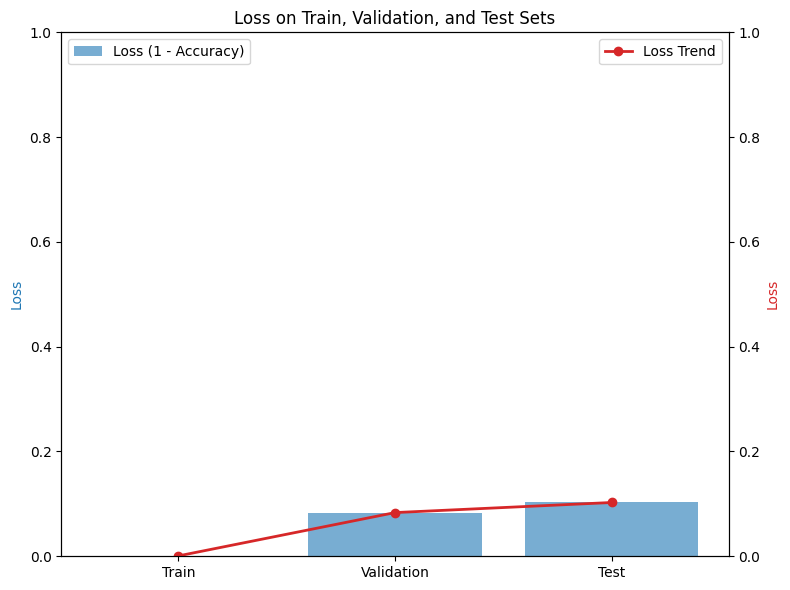

Training accuracy: 0.9993
Validation accuracy: 0.9166
Test accuracy: 0.8973
F1 - micro: 0.8973
Precision (micro): 0.8973
Recall (micro): 0.8973


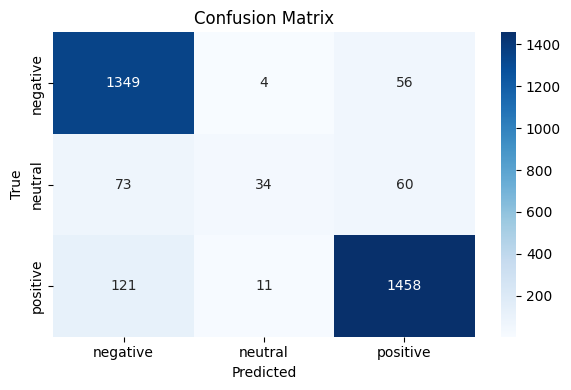

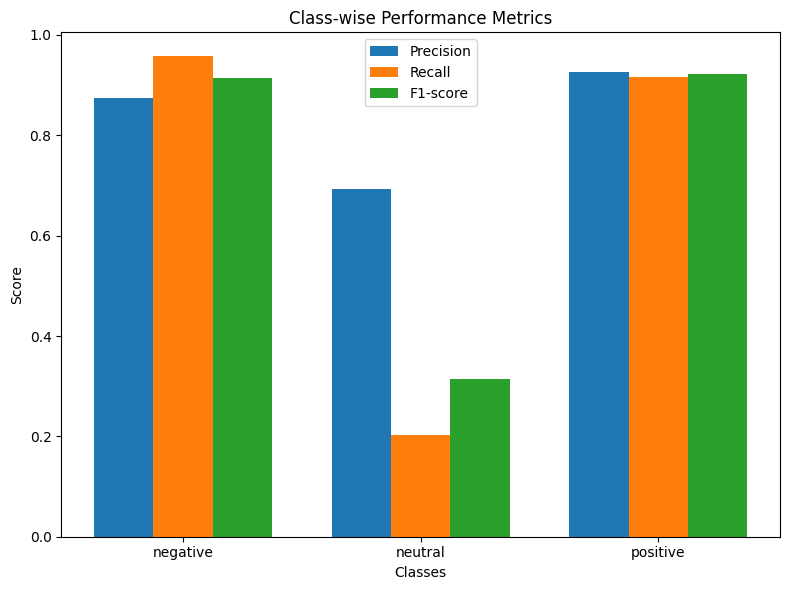


Example predictions:
------------------------
Text: nói tiếng anh lưu loát...
True sentiment: 2
Predicted sentiment: 2
------------------------
Text: giáo viên rất vui tính...
True sentiment: 2
Predicted sentiment: 2
------------------------
Text: cô max có tâm...
True sentiment: 2
Predicted sentiment: 2
------------------------
Text: giảng bài thu hút dí dỏm...
True sentiment: 2
Predicted sentiment: 2
------------------------
Text: giáo viên không giảng dạy kiến thức hướng dẫn thực...
True sentiment: 0
Predicted sentiment: 0
------------------------
Text: thầy dạy nhiệt tình và tâm huyết...
True sentiment: 2
Predicted sentiment: 2
------------------------
Text: tính điểm thi đua các nhóm...
True sentiment: 2
Predicted sentiment: 1
------------------------
Text: thầy nhiệt tình giảng lại cho học sinh...
True sentiment: 2
Predicted sentiment: 2
------------------------
Text: có đôi lúc nói hơi nhanh làm sinh viên không theo ...
True sentiment: 0
Predicted sentiment: 0
-----------------

ImportError: cannot import name 'joblib' from 'sklearn.externals' (/usr/local/lib/python3.12/dist-packages/sklearn/externals/__init__.py)

In [ ]:
# Support Vector Machine (SVM) Implementation with Visualizations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from google.colab import drive


# Preprocessing - assuming pre_process_features function is defined elsewhere
train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased=False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased=False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased=False)

# Check label distribution
print(f"Label distribution in training set: {np.bincount(train_y)}")
print(f"Label distribution in dev set: {np.bincount(dev_y)}")
print(f"Label distribution in test set: {np.bincount(test_y)}")

# Create a pipeline with TfidfVectorizer and SVM
print("Creating SVM pipeline...")
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
])

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto', 0.1, 0.01]
}

print("Performing hyperparameter tuning...")
grid_search = GridSearchCV(
    svm_pipeline,
    param_grid,
    cv=3,
    scoring='f1_micro',  # Changed to micro F1 score
    verbose=1,
    n_jobs=-1
)

# Fit the grid search to find the best parameters
grid_search.fit(train_X, train_y)

# Get the best parameters and model
best_params = grid_search.best_params_
best_svm = grid_search.best_estimator_
print(f"Best parameters: {best_params}")

# Train with the optimal parameters
print("Training final SVM model with optimal parameters...")
best_svm.fit(train_X, train_y)

# Make predictions on validation and test sets
print("Making predictions...")
dev_pred = best_svm.predict(dev_X)
test_pred = best_svm.predict(test_X)

# Calculate probabilities for ROC curve
test_probs = best_svm.predict_proba(test_X)

# Get training, validation, and test accuracy
train_acc = best_svm.score(train_X, train_y)
dev_acc = accuracy_score(dev_y, dev_pred)
test_acc = accuracy_score(test_y, test_pred)

# -----------------------------
# Calculate "loss" as (1 - accuracy)
# -----------------------------
train_loss = 1 - train_acc
dev_loss = 1 - dev_acc
test_loss = 1 - test_acc

# -----------------------------
# Plotting Losses - Line + Bar Plot
# -----------------------------
losses = [train_loss, dev_loss, test_loss]
datasets = ['Train', 'Validation', 'Test']

fig, ax1 = plt.subplots(figsize=(8, 6))

# Bar plot
color = 'tab:blue'
ax1.bar(datasets, losses, color=color, alpha=0.6, label='Loss (1 - Accuracy)')
ax1.set_ylabel('Loss', color=color)
ax1.set_ylim(0, 1)
ax1.set_title('Loss on Train, Validation, and Test Sets')
ax1.legend(loc='upper left')

# Line plot
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(datasets, losses, color=color, marker='o', linewidth=2, label='Loss Trend')
ax2.set_ylabel('Loss', color=color)
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.savefig('/content/drive/MyDrive/NCKH_2425/svm_losses.png')
plt.show()

print(f"Training accuracy: {train_acc:.4f}")
print(f"Validation accuracy: {dev_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Calculate metrics for test set (only micro metrics)
f1_micro = f1_score(test_y, test_pred, average='micro')
precision_micro = precision_score(test_y, test_pred, average='micro')
recall_micro = recall_score(test_y, test_pred, average='micro')

print(f"F1 - micro: {f1_micro:.4f}")
print(f"Precision (micro): {precision_micro:.4f}")
print(f"Recall (micro): {recall_micro:.4f}")

model_name = "SVM"

metrics = {
    "accuracy": test_acc,
    "f1_micro": f1_micro,
    "precision_micro": precision_micro,
    "recall_micro": recall_micro
}

all_results[model_name] = metrics

# Confusion Matrix
cf_matrix = confusion_matrix(test_y, test_pred)
plt.figure(figsize=(6, 4))
sn.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues",
           xticklabels=["negative", "neutral", "positive"],
           yticklabels=["negative", "neutral", "positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/NCKH_2425/confusion_matrix.png')
plt.show()

# Class-wise metrics
class_names = ["negative", "neutral", "positive"]
class_precision = precision_score(test_y, test_pred, average=None)
class_recall = recall_score(test_y, test_pred, average=None)
class_f1 = f1_score(test_y, test_pred, average=None)

plt.figure(figsize=(8, 6))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, class_precision, width, label='Precision')
plt.bar(x, class_recall, width, label='Recall')
plt.bar(x + width, class_f1, width, label='F1-score')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Class-wise Performance Metrics')
plt.xticks(x, class_names)
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/NCKH_2425/svm_class_metrics.png')
plt.show()

# Print some example predictions
print("\nExample predictions:")
print("------------------------")
for i in range(min(10, len(test_X))):
    print(f"Text: {test_X[i][:50]}...")
    print(f"True sentiment: {test_y[i]}")
    print(f"Predicted sentiment: {test_pred[i]}")
    print("------------------------")

# # Save model to Google Drive (if needed)
# from sklearn.externals import joblib
# save_path = '/content/drive/MyDrive/NCKH_2425/svm_model.pkl'
# joblib.dump(best_svm, save_path)
# print(f"SVM model saved to Google Drive at: {save_path}")

# LSTM

Label distribution in training set: [5325  458 5643]
Label distribution in dev set: [705  73 805]
Label distribution in test set: [1409  167 1590]
Tokenizing text data...
Vocabulary size: 2141
Building LSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training LSTM model...
Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7387 - loss: 0.6049
Epoch 1: val_loss improved from inf to 0.28417, saving model to /content/drive/MyDrive/NCKH_2425/LSTM/best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.7390 - loss: 0.6044 - val_accuracy: 0.9027 - val_loss: 0.2842
Epoch 2/10
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9066 - loss: 0.2903
Epoch 2: val_loss improved from 0.28417 to 0.25544, saving model to /content/drive/MyDrive/NCKH_2425/LSTM/best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.9066 - loss: 0.2902 - val_accuracy: 0.9172 - val_loss: 0.2554
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9262 - loss: 0.2315
Epoch 3: val_loss improved from 0.25544 to 0.25307, saving model to /content/drive/MyDrive/NCKH_2425/LSTM/best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.9262 - loss: 0.2314 - val_accuracy: 0.9179 - val_loss: 0.2531
Epoch 4/10
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9378 - loss: 0.1968
Epoch 4: val_loss did not improve from 0.25307
358/358 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.9378 - loss: 0.1968 - val_accuracy: 0.9172 - val_loss: 0.2566
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9508 - loss: 0.1644
Epoch 5: val_loss did not improve from 0.25307
358/358 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.9508 - loss: 0.1644 - val_accuracy: 0.9198 - val_loss: 0.2616
Epoch 6/10
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9571 - loss: 0.1427
Epoch 6: val_loss did not improve from 0.25307
358/358 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.9571 - loss: 0.1427 - val_accuracy: 0.9160 - val_loss: 0.3008


LSTM model saved to disk.
Evaluating on test set...
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8963 - loss: 0.3246
Test Loss: 0.3260
Test Accuracy: 0.8961
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
F1 - micro: 0.8961
Precision (micro): 0.8961
Recall (micro): 0.8961


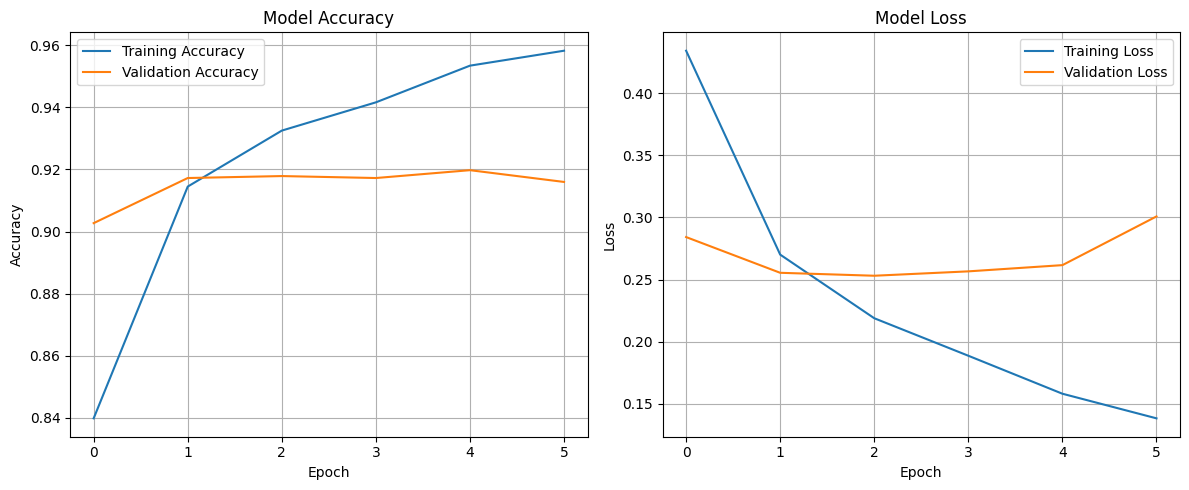

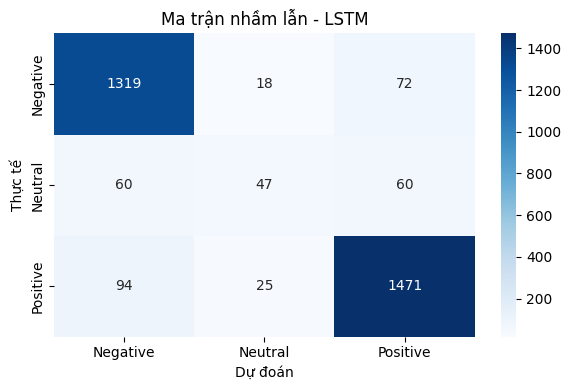

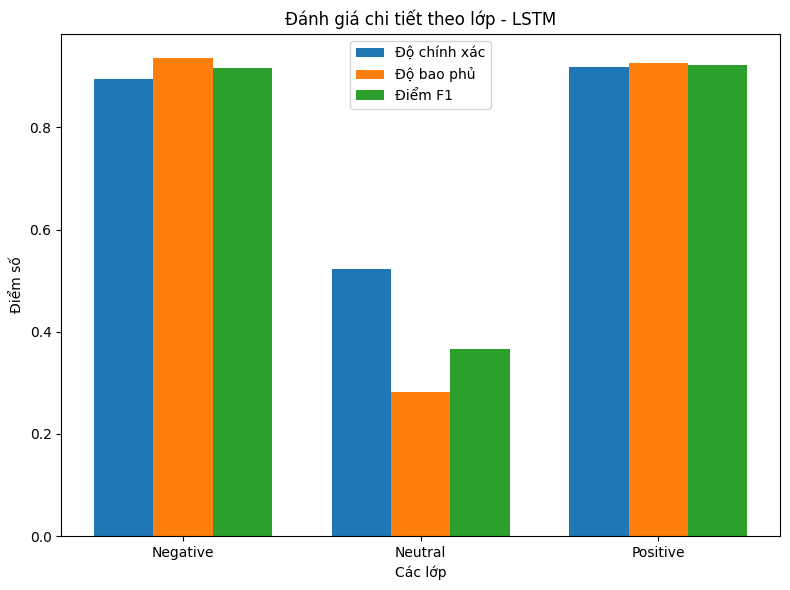

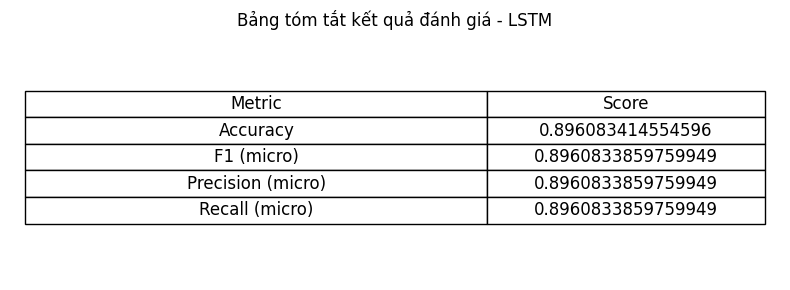

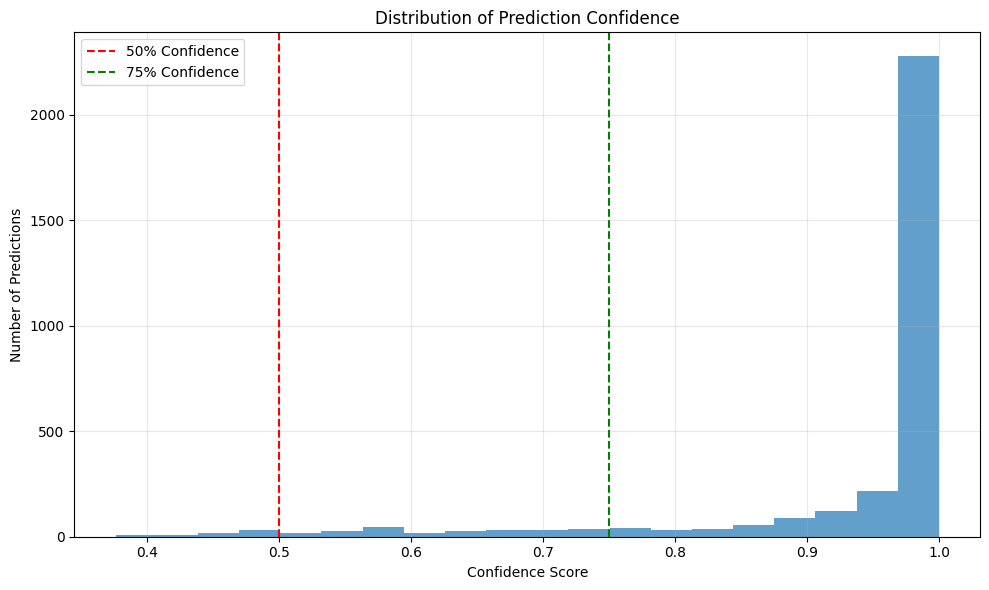

Text: giáo viên thờ ơ dạy cho có
True label: Negative
Predicted: Neutral with confidence 0.3758
--------------------------------------------------
Text: có lời cho công việc sau này của mình không
True label: Negative
Predicted: Neutral with confidence 0.3839
--------------------------------------------------
Text: chắc kiến thức cho sinh viên nếu mất nền tảng
True label: Positive
Predicted: Positive with confidence 0.3900
--------------------------------------------------
Text: em hoàn toàn hài lòng về phương pháp giảng dạy này
True label: Positive
Predicted: Positive with confidence 0.3927
--------------------------------------------------
Text: hoạt động cho mỗi nhóm lên thuyết trình về chủ đề đã được giao
True label: Neutral
Predicted: Negative with confidence 0.3934
--------------------------------------------------
Text: thuyết trình trước lớp bằng tiếng anh theo chủ đề
True label: Positive
Predicted: Neutral with confidence 0.3942
------------------------------------------------

In [ ]:
# LSTM Implementation with Visualizations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import os
import time
import datetime


# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Preprocessing - assuming pre_process_features function is defined elsewhere
train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased=False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased=False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased=False)

# Check label distribution
print(f"Label distribution in training set: {np.bincount(train_y)}")
print(f"Label distribution in dev set: {np.bincount(dev_y)}")
print(f"Label distribution in test set: {np.bincount(test_y)}")

# Text vectorization with Keras Tokenizer
max_words = 30000  # Maximum vocab size
max_len = 150      # Maximum sequence length

print("Tokenizing text data...")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
dev_sequences = tokenizer.texts_to_sequences(dev_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to the same length
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
dev_padded = pad_sequences(dev_sequences, maxlen=max_len, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Build LSTM model
print("Building LSTM model...")
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes
])

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Setup callbacks
checkpoint_path = "/content/drive/MyDrive/NCKH_2425/LSTM/best_model.h5"
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

# Train model
print("Training LSTM model...")
batch_size = 32
epochs = 10

history = model.fit(
    train_padded, train_y,
    validation_data=(dev_padded, dev_y),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

# Save the model
model.save("/content/drive/MyDrive/NCKH_2425/LSTM/lstm_final_model.h5")
print("LSTM model saved to disk.")

# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_acc = model.evaluate(test_padded, test_y)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Make predictions
y_pred_prob = model.predict(test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate metrics
f1_micro = f1_score(test_y, y_pred, average='micro')
precision = precision_score(test_y, y_pred, average='micro')
recall = recall_score(test_y, y_pred, average='micro')

print(f"F1 - micro: {f1_micro:.4f}")
print(f"Precision (micro): {precision:.4f}")
print(f"Recall (micro): {recall:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('lstm_training_history.png')
plt.show()

# Create confusion matrix
class_names = ["Negative", "Neutral", "Positive"]
cf_matrix = confusion_matrix(test_y, y_pred)
plt.figure(figsize=(6, 4))  # Smaller size
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues",
           xticklabels=class_names,
           yticklabels=class_names)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn - LSTM')
plt.tight_layout()
plt.savefig('lstm_confusion_matrix.png')
plt.show()

# Calculate class-wise metrics
class_precision = precision_score(test_y, y_pred, average=None)
class_recall = recall_score(test_y, y_pred, average=None)
class_f1 = f1_score(test_y, y_pred, average=None)

# Plot class-wise metrics
plt.figure(figsize=(8, 6))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, class_precision, width, label='Độ chính xác')
plt.bar(x, class_recall, width, label='Độ bao phủ')
plt.bar(x + width, class_f1, width, label='Điểm F1')

plt.xlabel('Các lớp')
plt.ylabel('Điểm số')
plt.title('Đánh giá chi tiết theo lớp - LSTM')
plt.xticks(x, class_names)
plt.legend()
plt.tight_layout()
plt.savefig('lstm_class_metrics.png')
plt.show()

# Create a summary table of all metrics
summary_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 (micro)', 'Precision (micro)', 'Recall (micro)'],
    'Score': [test_acc, f1_micro, precision, recall]
})

# Plot as a table
plt.figure(figsize=(8, 3))
plt.axis('off')
table = plt.table(cellText=summary_df.values,
                 colLabels=summary_df.columns,
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.5, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title('Bảng tóm tắt kết quả đánh giá - LSTM')
plt.tight_layout()
plt.savefig('lstm_metrics_summary.png')
plt.show()

# Plot prediction confidence
plt.figure(figsize=(10, 6))
confidence_scores = np.max(y_pred_prob, axis=1)
plt.hist(confidence_scores, bins=20, alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--', label='50% Confidence')
plt.axvline(x=0.75, color='green', linestyle='--', label='75% Confidence')
plt.title('Distribution of Prediction Confidence')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Predictions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_confidence_distribution.png')
plt.show()

model_name = "LSTM"
metrics = {
    "accuracy": test_acc,
    "f1_micro": f1_micro,
    "precision": precision,
    "recall": recall
}
all_results[model_name] = metrics

# Identify most uncertain predictions
uncertain_indices = np.argsort(confidence_scores)[:20]  # 20 most uncertain predictions
for idx in uncertain_indices:
    print(f"Text: {test_X[idx]}")
    print(f"True label: {class_names[test_y[idx]]}")
    print(f"Predicted: {class_names[y_pred[idx]]} with confidence {confidence_scores[idx]:.4f}")
    print("-" * 50)

# Compare

In [ ]:
import { useState } from 'react';
import {
  BarChart,
  Bar,
  XAxis,
  YAxis,
  CartesianGrid,
  Tooltip,
  Legend,
  ResponsiveContainer,
  RadarChart,
  PolarGrid,
  PolarAngleAxis,
  PolarRadiusAxis,
  Radar
} from 'recharts';

export default function ModelComparisonCharts() {
  // Giả định dữ liệu từ all_results
  #const all_results = {
  #   "ViBert4News": {
  #     "accuracy": 0.89,
  #     "f1_micro": 0.88,
  #     "precision": 0.87,
  #     "recall": 0.88
  #   },
  #   "PhoBERT": {
  #     "accuracy": 0.92,
  #     "f1_micro": 0.91,
  #     "precision": 0.90,
  #     "recall": 0.92
  #   },
  #   "mBERT": {
  #     "accuracy": 0.85,
  #     "f1_micro": 0.84,
  #     "precision": 0.83,
  #     "recall": 0.85
  #   },
  #   "XLM-R": {
  #     "accuracy": 0.91,
  #     "f1_micro": 0.90,
  #     "precision": 0.89,
  #     "recall": 0.90
  #   },
  #   "ViT5": {
  #     "accuracy": 0.88,
  #     "f1_micro": 0.87,
  #     "precision": 0.86,
  #     "recall": 0.88
  #   },
  #   "BARTpho": {
  #     "accuracy": 0.90,
  #     "f1_micro": 0.89,
  #     "precision": 0.88,
  #     "recall": 0.90
  #   }
  # };

  // Chuyển đổi dữ liệu cho biểu đồ cột
  const barChartData = Object.keys(all_results).map(model => {
    return {
      model,
      ...all_results[model]
    };
  });

  // Chuyển đổi dữ liệu cho biểu đồ radar
  const radarChartData = [
    { subject: 'Accuracy', ...Object.keys(all_results).reduce((acc, model) => {
      acc[model] = all_results[model].accuracy;
      return acc;
    }, {})},
    { subject: 'F1 Micro', ...Object.keys(all_results).reduce((acc, model) => {
      acc[model] = all_results[model].f1_micro;
      return acc;
    }, {})},
    { subject: 'Precision', ...Object.keys(all_results).reduce((acc, model) => {
      acc[model] = all_results[model].precision;
      return acc;
    }, {})},
    { subject: 'Recall', ...Object.keys(all_results).reduce((acc, model) => {
      acc[model] = all_results[model].recall;
      return acc;
    }, {})}
  ];

  // Danh sách các mô hình và colors cho biểu đồ
  const models = Object.keys(all_results);
  const colors = ['#8884d8', '#82ca9d', '#ffc658', '#ff8042', '#0088fe', '#00C49F'];

  const [selectedModel, setSelectedModel] = useState(models[0]);

  return (
    <div className="flex flex-col space-y-8 p-4">
      <h1 className="text-2xl font-bold text-center">So Sánh Hiệu Suất Các Mô Hình NLP</h1>

      {/* Biểu đồ cột so sánh tất cả metrics của tất cả các mô hình */}
      <div className="space-y-2">
        <h2 className="text-xl font-semibold">So Sánh Tất Cả Metrics</h2>
        <div className="h-96">
          <ResponsiveContainer width="100%" height="100%">
            <BarChart
              data={barChartData}
              margin={{ top: 20, right: 30, left: 20, bottom: 70 }}
            >
              <CartesianGrid strokeDasharray="3 3" />
              <XAxis dataKey="model" angle={-45} textAnchor="end" interval={0} height={70} />
              <YAxis domain={[0, 1]} />
              <Tooltip formatter={(value) => (value * 100).toFixed(1) + '%'} />
              <Legend />
              <Bar dataKey="accuracy" name="Accuracy" fill="#8884d8" />
              <Bar dataKey="f1_micro" name="F1 Micro" fill="#82ca9d" />
              <Bar dataKey="precision" name="Precision" fill="#ffc658" />
              <Bar dataKey="recall" name="Recall" fill="#ff8042" />
            </BarChart>
          </ResponsiveContainer>
        </div>
      </div>

      {/* Biểu đồ radar cho từng mô hình */}
      <div className="space-y-2">
        <div className="flex items-center justify-between">
          <h2 className="text-xl font-semibold">Phân Tích Hiệu Suất Theo Mô Hình</h2>
          <div className="flex items-center space-x-2">
            <label className="text-sm font-medium">Chọn Mô Hình:</label>
            <select
              className="border rounded p-1"
              value={selectedModel}
              onChange={(e) => setSelectedModel(e.target.value)}
            >
              {models.map(model => (
                <option key={model} value={model}>{model}</option>
              ))}
            </select>
          </div>
        </div>

        <div className="flex flex-wrap">
          {/* Biểu đồ Radar */}
          <div className="w-full md:w-1/2 h-80">
            <ResponsiveContainer width="100%" height="100%">
              <RadarChart outerRadius={90} data={radarChartData}>
                <PolarGrid />
                <PolarAngleAxis dataKey="subject" />
                <PolarRadiusAxis angle={30} domain={[0, 1]} />
                {models.map((model, index) => (
                  <Radar
                    key={model}
                    name={model}
                    dataKey={model}
                    stroke={colors[index % colors.length]}
                    fill={colors[index % colors.length]}
                    fillOpacity={model === selectedModel ? 0.6 : 0.1}
                    strokeWidth={model === selectedModel ? 2 : 1}
                  />
                ))}
                <Legend />
                <Tooltip formatter={(value) => (value * 100).toFixed(1) + '%'} />
              </RadarChart>
            </ResponsiveContainer>
          </div>

          {/* Bảng so sánh chi tiết */}
          <div className="w-full md:w-1/2 p-4">
            <h3 className="text-lg font-medium mb-2">Chi Tiết Metrics: {selectedModel}</h3>
            <div className="border rounded overflow-hidden">
              <table className="min-w-full divide-y divide-gray-200">
                <thead className="bg-gray-100">
                  <tr>
                    <th className="p-2 text-left text-sm font-medium">Metric</th>
                    <th className="p-2 text-left text-sm font-medium">Giá Trị</th>
                  </tr>
                </thead>
                <tbody className="bg-white divide-y divide-gray-200">
                  {Object.entries(all_results[selectedModel]).map(([metric, value]) => (
                    <tr key={metric}>
                      <td className="p-2 text-sm">{metric.charAt(0).toUpperCase() + metric.slice(1)}</td>
                      <td className="p-2 text-sm">{(value * 100).toFixed(2)}%</td>
                    </tr>
                  ))}
                </tbody>
              </table>
            </div>
          </div>
        </div>
      </div>

      {/* Biểu đồ so sánh từng metric giữa các mô hình */}
      <div className="space-y-4">
        <h2 className="text-xl font-semibold">So Sánh Từng Metric</h2>
        <div className="grid grid-cols-1 md:grid-cols-2 gap-6">
          {['accuracy', 'f1_micro', 'precision', 'recall'].map(metric => (
            <div key={metric} className="h-64">
              <h3 className="text-lg font-medium mb-1 capitalize">{metric.replace('_', ' ')}</h3>
              <ResponsiveContainer width="100%" height="90%">
                <BarChart
                  data={barChartData}
                  margin={{ top: 5, right: 30, left: 20, bottom: 30 }}
                >
                  <CartesianGrid strokeDasharray="3 3" />
                  <XAxis dataKey="model" angle={-45} textAnchor="end" interval={0} height={50} />
                  <YAxis domain={[0, 1]} />
                  <Tooltip formatter={(value) => (value * 100).toFixed(1) + '%'} />
                  <Bar
                    dataKey={metric}
                    fill="#8884d8"
                    name={metric.charAt(0).toUpperCase() + metric.slice(1).replace('_', ' ')}
                  />
                </BarChart>
              </ResponsiveContainer>
            </div>
          ))}
        </div>
      </div>
    </div>
  );
}

# DEMO

In [ ]:
!pip install transformers underthesea



In [ ]:
import torch
import re
import numpy as np
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from underthesea import ner, word_tokenize, pos_tag
from sklearn.preprocessing import LabelEncoder

# Properly configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hàm tiền xử lý văn bản giữ nguyên
def load_stopwords(file_path):
    """Đọc danh sách stopwords từ file"""
    with open(file_path, "r", encoding="utf-8") as ins:
        stopwords = [line.strip('\n') for line in ins]
    return set(stopwords)

def filter_stop_words(text, stop_words):
    """Loại bỏ stopwords khỏi văn bản"""
    new_sent = [word for word in text.split() if word not in stop_words]
    return ' '.join(new_sent)

def deEmojify(text):
    """Loại bỏ emoji khỏi văn bản"""
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess_text(text, tokenizer=None, remove_stopwords=False, stopwords=None,
                   remove_emoji=True, lowercase=True):
    """Tiền xử lý văn bản tổng hợp"""
    if remove_emoji:
        text = deEmojify(text)

    # Tokenize nếu có tokenizer
    if tokenizer:
        sentences = tokenizer.tokenize(text)
        text = " ".join([" ".join(sentence) for sentence in sentences])

    # Loại bỏ stopwords nếu cần
    if remove_stopwords and stopwords:
        text = filter_stop_words(text, stopwords)

    # Chuyển về chữ thường nếu cần
    if lowercase:
        text = text.lower()

    return text

# Tải và chuẩn bị mô hình phân loại cảm xúc
def load_sentiment_model(model_path, tokenizer_name="vinai/phobert-base-v2"):
    """Tải mô hình phân loại cảm xúc"""
    # Sửa lỗi: Đảm bảo model được tải đúng cách trước khi đưa vào pipeline
    try:
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=False)
        model = AutoModelForSequenceClassification.from_pretrained(model_path)

        # Move model to device after loading
        model = model.to(device)

        # Create pipeline after moving model to device
        device_id = 0 if device.type == "cuda" else -1
        sentiment_classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device_id)

        return sentiment_classifier, tokenizer
    except Exception as e:
        print(f"Error loading model: {e}")
        # Fallback to CPU if there's an issue with GPU
        print("Falling back to CPU")
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=False)
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        sentiment_classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=-1)
        return sentiment_classifier, tokenizer

# PHƯƠNG PHÁP CẢI TIẾN 1: Phân tích từng từ với ngữ cảnh linh hoạt
def analyze_words_sentiment_adaptive(text, sentiment_classifier, min_window=3, max_window=7):
    """Phân tích cảm xúc của từng từ với kích thước cửa sổ ngữ cảnh linh hoạt"""
    words = word_tokenize(text, format="text").split()
    pos_tags = pos_tag(text)  # Trả về dạng [(word, tag)]

    # Lọc chỉ lấy danh từ (N), động từ (V), tính từ (A), phó từ (R)
    filtered_words_with_pos = [(word, tag) for word, tag in pos_tags if tag.startswith(("N", "V", "A", "R"))]
    filtered_words = [word for word, _ in filtered_words_with_pos]

    # Từ điển lưu cảm xúc của từng từ và độ tin cậy
    word_sentiments = {}

    for i, word in enumerate(words):
        if word not in filtered_words:
            continue

        # Lấy POS tag của từ
        word_tag = next((tag for w, tag in filtered_words_with_pos if w == word), None)

        # Điều chỉnh kích thước cửa sổ dựa vào loại từ
        if word_tag and word_tag.startswith('A'):  # Tính từ - window nhỏ hơn
            window_size = min_window
        elif word_tag and word_tag.startswith('N'):  # Danh từ - window trung bình
            window_size = (min_window + max_window) // 2
        else:  # Động từ, phó từ - window lớn hơn
            window_size = max_window

        start = max(0, i - window_size // 2)
        end = min(len(words), i + window_size // 2 + 1)
        phrase = " ".join(words[start:end])

        try:
            result = sentiment_classifier(phrase)
            label = result[0]["label"]
            score = result[0]["score"]
            sentiment = {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}[label]

            # Lưu cả cảm xúc và độ tin cậy
            word_sentiments[word] = {
                "sentiment": sentiment,
                "confidence": score,
                "context": phrase
            }
        except Exception as e:
            print(f"⚠️ Bỏ qua cụm '{phrase}' do lỗi: {e}")
            continue

    return word_sentiments

# PHƯƠNG PHÁP CẢI TIẾN 2: Phân tích theo cụm từ có ý nghĩa
def analyze_phrases_sentiment(text, sentiment_classifier):
    """Phân tích cảm xúc theo cụm từ có ý nghĩa"""
    # Sử dụng NER để tìm các thực thể có tên
    entities = ner(text)

    # Phân tích từ loại để xác định cụm danh từ tiềm năng
    pos_tags = pos_tag(text)

    # Trích xuất các cụm danh từ (N + A), động từ + danh từ (V + N), v.v.
    phrases = []
    i = 0
    while i < len(pos_tags) - 1:
        word, tag = pos_tags[i]

        # Tìm cụm "danh từ + tính từ" hoặc "tính từ + danh từ"
        if (tag.startswith('N') and i+1 < len(pos_tags) and pos_tags[i+1][1].startswith('A')) or \
           (tag.startswith('A') and i+1 < len(pos_tags) and pos_tags[i+1][1].startswith('N')):
            phrases.append(" ".join([pos_tags[i][0], pos_tags[i+1][0]]))
            i += 2

        # Tìm cụm "động từ + danh từ"
        elif tag.startswith('V') and i+1 < len(pos_tags) and pos_tags[i+1][1].startswith('N'):
            phrases.append(" ".join([pos_tags[i][0], pos_tags[i+1][0]]))
            i += 2

        # Tìm cụm "động từ + phó từ" hoặc "phó từ + động từ"
        elif (tag.startswith('V') and i+1 < len(pos_tags) and pos_tags[i+1][1].startswith('R')) or \
             (tag.startswith('R') and i+1 < len(pos_tags) and pos_tags[i+1][1].startswith('V')):
            phrases.append(" ".join([pos_tags[i][0], pos_tags[i+1][0]]))
            i += 2

        # Tìm cụm "phó từ + tính từ"
        elif tag.startswith('R') and i+1 < len(pos_tags) and pos_tags[i+1][1].startswith('A'):
            phrases.append(" ".join([pos_tags[i][0], pos_tags[i+1][0]]))
            i += 2

        else:
            # Danh từ, động từ, tính từ đơn lẻ có ý nghĩa
            if tag.startswith(('N', 'V', 'A')) and len(word) > 1:  # Tránh các từ đơn
                phrases.append(word)
            i += 1

    # Thêm các thực thể đã xác định từ NER
    for entity in entities:
        if isinstance(entity, tuple) and len(entity) >= 3:  # Dạng [(word, tag, probability), ...]
            entity_text = entity[0]
            if len(entity_text.split()) > 1:  # Chỉ lấy các thực thể multi-word
                phrases.append(entity_text)

    # Loại bỏ trùng lặp
    phrases = list(set(phrases))

    # Phân tích cảm xúc cho từng cụm
    phrase_sentiments = {}
    for phrase in phrases:
        try:
            result = sentiment_classifier(phrase)
            label = result[0]["label"]
            score = result[0]["score"]
            sentiment = {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}[label]

            # Chỉ lưu các cụm có cảm xúc rõ ràng (độ tin cậy cao)
            if score > 0.7 and sentiment != "Neutral":
                phrase_sentiments[phrase] = {
                    "sentiment": sentiment,
                    "confidence": score
                }
        except Exception as e:
            print(f"⚠️ Bỏ qua cụm '{phrase}' do lỗi: {e}")
            continue

    return phrase_sentiments

# PHƯƠNG PHÁP CẢI TIẾN 3: Kết hợp phân tích và lọc kết quả chất lượng
def extract_sentiment_words(text, sentiment_classifier, threshold=0.75):
    """Kết hợp các phương pháp và lọc kết quả chất lượng cao"""
    # Tiền xử lý văn bản
    processed_text = preprocess_text(text, remove_emoji=True, lowercase=True)

    # Phân tích theo từ với ngữ cảnh linh hoạt
    word_sentiments = analyze_words_sentiment_adaptive(processed_text, sentiment_classifier)

    # Phân tích theo cụm từ có ý nghĩa
    phrase_sentiments = analyze_phrases_sentiment(processed_text, sentiment_classifier)

    # Kết hợp và lọc kết quả
    all_sentiment_items = {}

    # Thêm cảm xúc từ word_sentiments có độ tin cậy cao
    for word, data in word_sentiments.items():
        if data["confidence"] >= threshold:
            all_sentiment_items[word] = data

    # Thêm cảm xúc từ phrase_sentiments
    for phrase, data in phrase_sentiments.items():
        if data["confidence"] >= threshold:
            all_sentiment_items[phrase] = data

    # Phân loại theo cảm xúc
    positive_items = {k: v for k, v in all_sentiment_items.items() if v["sentiment"] == "Positive"}
    negative_items = {k: v for k, v in all_sentiment_items.items() if v["sentiment"] == "Negative"}
    neutral_items = {k: v for k, v in all_sentiment_items.items() if v["sentiment"] == "Neutral"}

    # Sắp xếp theo độ tin cậy (từ cao đến thấp)
    positive_items = dict(sorted(positive_items.items(), key=lambda x: x[1]["confidence"], reverse=True))
    negative_items = dict(sorted(negative_items.items(), key=lambda x: x[1]["confidence"], reverse=True))
    neutral_items = dict(sorted(neutral_items.items(), key=lambda x: x[1]["confidence"], reverse=True))

    return {
        "positive": positive_items,
        "negative": negative_items,
        "neutral": neutral_items
    }

# Phân tích cảm xúc toàn câu
def analyze_full_sentence_sentiment(text, sentiment_classifier):
    """Phân tích cảm xúc của toàn bộ câu"""
    try:
        results = sentiment_classifier(text)
        predicted_label = results[0]["label"]
        predicted_score = results[0]["score"]
        attitude_map = {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}
        return attitude_map.get(predicted_label, "Unknown"), predicted_score
    except Exception as e:
        print(f"Lỗi khi phân tích cảm xúc toàn câu: {e}")
        return "Unknown", 0.0

# Hàm chính để sử dụng
def analyze_sentiment_words(text, model_path, stopwords_path=None):
    """Hàm chính để phân tích từ tình cảm trong văn bản"""
    # Tải mô hình cảm xúc
    print("Đang tải mô hình sentiment...")
    sentiment_classifier, tokenizer = load_sentiment_model(model_path)
    print("Đã tải xong mô hình sentiment")

    # Tải stopwords nếu có
    stopwords = None
    if stopwords_path:
        try:
            stopwords = load_stopwords(stopwords_path)
            print(f"Đã tải {len(stopwords)} stopwords")
        except Exception as e:
            print(f"Không thể tải stopwords: {e}")
            print("Tiếp tục mà không có stopwords")

    # Tiền xử lý văn bản
    processed_text = preprocess_text(text, remove_emoji=True, lowercase=True,
                                   remove_stopwords=bool(stopwords), stopwords=stopwords)

    # Phân tích cảm xúc toàn văn
    print("\n🔍 Đang phân tích cảm xúc toàn văn...")
    attitude, score = analyze_full_sentence_sentiment(processed_text, sentiment_classifier)

    # Trích xuất từ tình cảm
    print("\n🔍 Đang trích xuất từ tình cảm...")
    sentiment_items = extract_sentiment_words(processed_text, sentiment_classifier)

    # In kết quả
    print(f"\n✅ Kết quả phân tích cảm xúc:")
    print(f"✅ Cảm xúc tổng thể: {attitude} (điểm: {score:.2f})")

    # Hiển thị các từ tích cực
    positive_words = list(sentiment_items["positive"].keys())
    print(f"✅ Từ tích cực ({len(positive_words)}): {', '.join(positive_words[:15])}{'...' if len(positive_words) > 15 else ''}")

    # Hiển thị các từ tiêu cực
    negative_words = list(sentiment_items["negative"].keys())
    print(f"✅ Từ tiêu cực ({len(negative_words)}): {', '.join(negative_words[:15])}{'...' if len(negative_words) > 15 else ''}")

    # Hiển thị các từ trung tính
    neutral_words = list(sentiment_items["neutral"].keys())
    print(f"✅ Từ trung tính ({len(neutral_words)}): {', '.join(neutral_words[:15])}{'...' if len(neutral_words) > 15 else ''}")

    # Trả về kết quả để sử dụng trong các hàm khác
    return {
        "overall_sentiment": attitude,
        "overall_score": score,
        "sentiment_items": sentiment_items
    }

# Ví dụ sử dụng
if __name__ == "__main__":
    # Thiết lập đường dẫn
    model_path = "/content/drive/MyDrive/NCKH_2425/ViBert4News/Base"
    model_path_2 = "/content/drive/MyDrive/NCKH_2425/PhoBERT/PhoBERT_base_v2"
    model_path_3 = "/content/drive/MyDrive/NCKH_2425/XLM-RoBERTa"
    stopwords_path = "/content/drive/MyDrive/NCKH_2425/DATASET/#dataVNstopwords/vietnamese-stopwords-dash.txt"

    # Văn bản ví dụ
    example_text = """Hỏi thật là đi cổ vũ Đường Đến Thành Công có được cộng điểm rèn luyện k vậy ạ. Chứ năm nào mình cũng đi có thấy được cộng mục nào đâu"""

    # Phân tích
    results = analyze_sentiment_words(example_text, model_path, stopwords_path)
    results_2 = analyze_sentiment_words(example_text, model_path_2, stopwords_path)
    results_3 = analyze_sentiment_words(example_text, model_path_3, stopwords_path)

In [ ]:
# Bert4news - Training on Colab

# 1. Import libraries
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, precision_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback, TrainerCallback, set_seed

# 2. Setup
# Set environment variables for better logging
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

# Set random seed
set_seed(42)

# Label mapping
label_mapping = {0: "negative", 1: "neutral", 2: "positive"}

# Model & output directory (for Colab)
base_model_dir = "/content/drive/MyDrive/NCKH_2425/ViBert4News/Base"

# 3. Preprocess data
train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased=False)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=False, lowercased=False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased=False)

print(f"Label distribution in training set: {np.bincount(train_y)}")
print(f"Label distribution in dev set: {np.bincount(dev_y)}")
print(f"Label distribution in test set: {np.bincount(test_y)}")

# 4. Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(base_model_dir, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(base_model_dir, use_fast=True)

# 5. Dataset class
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize data
train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=512)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=512)

# Create datasets
train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

# 6. Custom Loss Tracking Callback
class LossTrackingCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.test_losses = []
        self.steps = []
        self.epochs = []
        self.trainer = None
        self.test_dataset = None

    def on_train_begin(self, args, state, control, **kwargs):
        if 'trainer' in kwargs:
            self.trainer = kwargs['trainer']

    def set_trainer_and_dataset(self, trainer, test_dataset):
        self.trainer = trainer
        self.test_dataset = test_dataset

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_losses.append(logs["loss"])
                self.steps.append(state.global_step)
            if "eval_loss" in logs:
                self.eval_losses.append(logs["eval_loss"])
                if self.trainer is not None and self.test_dataset is not None:
                    test_outputs = self.trainer.predict(self.test_dataset)
                    test_loss = test_outputs.metrics["test_loss"]
                    self.test_losses.append(test_loss)
                    self.epochs.append(state.epoch)
                    print(f"Epoch {state.epoch:.2f}: Eval loss: {logs['eval_loss']:.4f}, Test loss: {test_loss:.4f}")

# 7. Training arguments
training_args = TrainingArguments(
    output_dir=base_model_dir,
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    no_cuda=False,
    do_eval=True
)

# Early stopping
# early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

# Initialize loss tracker
loss_tracker = LossTrackingCallback()

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    callbacks=[loss_tracker],
)

loss_tracker.set_trainer_and_dataset(trainer, test_dataset)

# 8. Train model
print("Starting training...")
trainer.train()
trainer.save_model(base_model_dir)
print("Training completed and model saved.")

# 9. Plot training, validation, and test loss
plt.figure(figsize=(10, 6))
plt.plot(loss_tracker.steps, loss_tracker.train_losses, label='Training Loss')

if loss_tracker.eval_losses and loss_tracker.test_losses:
    eval_step_interval = max(1, len(loss_tracker.steps) // len(loss_tracker.eval_losses))
    eval_steps = [loss_tracker.steps[min(i * eval_step_interval, len(loss_tracker.steps) - 1)] for i in range(len(loss_tracker.eval_losses))]
    plt.plot(eval_steps, loss_tracker.eval_losses, label='Validation Loss')
    plt.plot(eval_steps, loss_tracker.test_losses, label='Test Loss')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curves.png')
plt.show()

# 10. Evaluate on test set
y_pred_classify = trainer.predict(test_dataset)
y_pred_ids = np.argmax(y_pred_classify.predictions, axis=-1)

# Map IDs to text labels
y_pred_text = [label_mapping[idx] for idx in y_pred_ids]
y_true_text = [label_mapping[idx] for idx in test_y]

# Metrics
y_true = test_y

# Confusion Matrix
cf_matrix = confusion_matrix(y_true, y_pred_ids)
plt.figure(figsize=(6, 4))
sn.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues",
           xticklabels=["negative", "neutral", "positive"],
           yticklabels=["negative", "neutral", "positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Scores
acc = accuracy_score(y_true, y_pred_ids)
print("Accuracy: {:.4f}".format(acc))

f1_micro = f1_score(y_true, y_pred_ids, average='micro')
print("F1 - micro: {:.4f}".format(f1_micro))

# f1_macro = f1_score(y_true, y_pred_ids, average='macro')
# print("F1 - macro: {:.4f}".format(f1_macro))

precision = precision_score(y_true, y_pred_ids, average='micro')
print("Precision (micro): {:.4f}".format(precision))

recall = recall_score(y_true, y_pred_ids, average='micro')
print("Recall (micro): {:.4f}".format(recall))

# 11. Plot class-wise metrics
class_names = ["negative", "neutral", "positive"]
class_precision = precision_score(y_true, y_pred_ids, average=None)
class_recall = recall_score(y_true, y_pred_ids, average=None)
class_f1 = f1_score(y_true, y_pred_ids, average=None)

plt.figure(figsize=(8, 6))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, class_precision, width, label='Precision')
plt.bar(x, class_recall, width, label='Recall')
plt.bar(x + width, class_f1, width, label='F1-score')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Class-wise Performance Metrics')
plt.xticks(x, class_names)
plt.legend()
plt.tight_layout()
plt.savefig('vibert4news_class_metrics.png')
plt.show()

# 12. Print some example predictions
print("\nExample predictions:")
print("------------------------")
for i in range(min(10, len(test_X))):
    print(f"Text: {test_X[i][:50]}...")
    print(f"True sentiment: {y_true_text[i]}")
    print(f"Predicted sentiment: {y_pred_text[i]}")
    print("------------------------")

In [ ]:
import torch
import re
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from underthesea import ner, word_tokenize

# Thiết bị xử lý
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1️⃣ Đọc danh sách từ cảm xúc từ file vocab.xlsx
file_path = "/content/drive/MyDrive/NCKH_2425/DATASET/add_data/vocab.xlsx"
df = pd.read_excel(file_path)  # ✅ Đọc file
object_words = df["Object"].dropna().tolist()

# 2️⃣ Tải mô hình PhoBERT phân loại cảm xúc
sentiment_model_path = "/content/drive/MyDrive/NCKH_2425/ViBert4News/Base"
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_path).to("cpu")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)
sentiment_classifier = pipeline("text-classification", model=sentiment_model, tokenizer=tokenizer, device=-1)


# Mô hình Topic
topic_model_path = "/content/drive/MyDrive/NCKH_2425/PhoBERT/PhoBERT_base/Topic"
topic_model = AutoModelForSequenceClassification.from_pretrained(topic_model_path).to("cpu")
topic_classifier = pipeline("text-classification", model=topic_model, tokenizer=tokenizer, device=-1)

# 3️⃣ Hàm tìm các từ cảm xúc trong câu
def extract_sentiment_words(text, sentiment_words):
    return [word for word in sentiment_words if re.search(r'\b' + re.escape(word) + r'\b', text, re.IGNORECASE)]

# Phân tích cảm xúc từng từ trong câu
def analyze_words_sentiment(text):
    words = word_tokenize(text, format="text").split()
    word_sentiments = {}

    for word in words:
        inputs = tokenizer(word, return_tensors="pt", truncation=True, padding=True, max_length=512).to("cpu")
        outputs = sentiment_model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

        # Correcting the conditional structure
        if prediction == 2:
            word_sentiments[word] = "Positive"
        elif prediction == 0:
            word_sentiments[word] = "Negative"
        else:
            word_sentiments[word] = "Neutral"

    return word_sentiments


# Nhập câu để phân tích
text = "Tụi em là tập thể lớp, ngành Kỹ thuật xây dựng của trường, khóa 55 và 56, kính mong Ban Giám hiệu, Ban Đào tạo mở thêm cho tụi em một vài lớp học phần môn (Thủy lực - Thủy văn và Phân tích kết cấu F1). Vì giờ tụi em là năm cuối cả rồi, phần vì phải đăng ký những môn trong học kỳ chính, phần vì muốn trả nợ những môn còn nợ hoặc chưa đăng ký được. Em biết nguồn nhân lực giảng dạy của nhà trường còn thiếu và không đủ để mở thêm nhiều lớp... Nhưng em kính mong Ban lãnh đạo trường xem xét mở cho tụi em 2 môn trên. Tụi em cũng không còn nhiều sự lựa chọn nữa vì tâm lý ai cũng muốn ra trường cho đúng hạn, nhà trường và Ban Đào tạo thương tình mở cho tụi em thêm lớp. Em đã lên Ban Đào tạo viết đơn 1 lần rồi nhưng không có câu trả lời... Em thay mặt tập thể ngành Kỹ thuật xây dựng K55 và K56 xin chân thành cảm ơn, ân đức này xin ghi nhớ, kính mong admin đăng riêng giùm em, chân thành cảm ơn admin, chúc admin sức khỏe, mong admin truyền tải tâm tư nguyện vọng này cho nhà trường giùm tụi em"

# Phân tích cảm xúc từng từ
# word_sentiments = analyze_words_sentiment(text)
# positive_words_in_text = [word for word, sentiment in word_sentiments.items() if sentiment == "Positive"]
# negative_words_in_text = [word for word, sentiment in word_sentiments.items() if sentiment == "Negative"]

# 5️⃣ Phân tích cảm xúc toàn câu
results = sentiment_classifier(text)
predicted_label = results[0]["label"]
predicted_score = results[0]["score"]

attitude_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}
attitude = attitude_map.get(predicted_label, "Unknown")

# 6️⃣ Phân tích chủ đề
topic_result = topic_classifier(text)
topic_label = topic_result[0]["label"]
topic_score = topic_result[0]["score"]

topic_map = {
    "LABEL_0": "facility",
    "LABEL_1": "lecturer",
    "LABEL_2": "others",
    "LABEL_3": "training_program"
}
topic = topic_map.get(topic_label, "Unknown")

# 7️⃣ NER và tìm các từ đối tượng
extracted_object_words = extract_sentiment_words(text, object_words)

# 👉 In kết quả
print(f"✅ Predicted attitude: {attitude} (score: {predicted_score:.2f})")
print(f"✅ Predicted topic: {topic} (score: {topic_score:.2f})")
# print(f"✅ Positive words: {positive_words_in_text}")
# print(f"✅ Negative words: {negative_words_in_text}")
# print(f"✅ Extracted Object Words: {extracted_object_words}")
